In [1]:
root_dir = !pwd
root_dir = root_dir[0]
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
data_dir = os.path.join(root_dir, "Data/habitat_sim", "2t7WUuJeko7_2_mini")

import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode
from scipy.spatial.distance import directed_hausdorff
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

In [2]:
# @markdown meters per cell size
cs = 0.025 # @param {type: "number"} 
# @markdown map resolution (gs x gs)
gs = 2000 # @param {type: "integer"}
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"}
# @markdown depth pixels subsample rate
depth_sample_rate = 10 # @param {type: "integer"}
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"}
mask_version = "dummy_geo_dist4_reverse3_4llava_wall4"

# Video

In [3]:
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

def get_fast_video_writer(video_file: str, fps: int = 60):
    if (
        "google.colab" in sys.modules
        and os.path.splitext(video_file)[-1] == ".mp4"
        and os.environ.get("IMAGEIO_FFMPEG_EXE") == "/usr/bin/ffmpeg"
    ):
        # USE GPU Accelerated Hardware Encoding
        writer = imageio.get_writer(
            video_file,
            fps=fps,
            codec=codec,
            mode="I",
            bitrate="1000k",
            format="FFMPEG",
            ffmpeg_log_level="info",
            quality=10,
            output_params=["-minrate", "500k", "-maxrate", "5000k"],
        )
    else:
        # Use software encoding
        writer = imageio.get_writer(video_file, fps=fps)
    return writer

def create_video(data_dir: str, output_dir: str, fps: int = 30):
    
    rgb_dir = os.path.join(data_dir, "rgb")
    depth_dir = os.path.join(data_dir, "depth")
    rgb_out_path = os.path.join(output_dir, "rgb.mp4")
    depth_out_path = os.path.join(output_dir, "depth.mp4")
    rgb_writer = get_fast_video_writer(rgb_out_path, fps=fps)
    depth_writer = get_fast_video_writer(depth_out_path, fps=fps)

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pbar = tqdm.tqdm(total=len(rgb_list), position=0, leave=True)
    for i, (rgb_path, depth_path) in enumerate(zip(rgb_list, depth_list)):
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        depth = load_depth(depth_path)
        depth_vis = (depth / 10 * 255).astype(np.uint8)

        depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

        rgb_writer.append_data(rgb)
        depth_writer.append_data(depth_color)
        pbar.update(1)
    rgb_writer.close()
    depth_writer.close()

def show_video(video_path, video_width = 1080):
   
    video_file = open(video_path, "r+b").read()
  
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>""")

def show_videos(video_paths, video_width = 1080):
    html = ""
    for video_path in video_paths:
        video_file = open(video_path, "r+b").read()
      
        video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
        html += f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>
                 """
    return HTML(html)

In [4]:
# create_video(data_dir, data_dir, fps=30)

In [5]:
# show rgb and depth
# show_videos([data_dir + "/rgb.mp4", data_dir + "/depth.mp4"])


# Create a VLMap

## SEEM Model

In [6]:
from PIL import Image
import numpy as np
import torch

from seem.base_model import build_vl_model
from seem.xdecoder_seem.xdecoder.architectures.seem_model import SEEM_Model

In [7]:
def from_file(rgb_path, depth_path):
    rgb = np.array(Image.open(rgb_path), dtype=np.uint8)
    depth = np.array(Image.open(depth_path), dtype=np.uint16)
    # if self.inverse_scale != 1:
    #     rgb = rgb[::2, ::2]
    #     depth = depth[::2, ::2]
    if rgb.shape != depth.shape:
        rgb = np.array(Image.fromarray(rgb).resize((depth.shape[1], depth.shape[0])), dtype=np.uint8)
    return rgb, depth

In [8]:
def get_SEEM_feat(model, image: np.array):
    features = model.encode_image([image], mode="default")[0]
    num_categories = len(features["category_id"])
    category_id = features["category_id"]
    map_conf = features["conf_score"]
    map_idx = features["conf_idx"] #! 0 index가 어떠한 mask에도 해당되지 못한 친구! -> embeddings에서 뽑을 때, 0은 안보고 1부터 찾으며, -1을 적용해서 찾아줘야겠지
    #! 0인 경우에 대해서도 예외처리 해줘야됨 나중에 가중평균 낼 때 -> 0*0 =0이니깐 => 0은 그냥 무시하고 저장하지 않는 등의
    embeddings = features["caption"]

    map_idx_np = map_idx.cpu().numpy()
    map_background = np.zeros_like(map_idx_np)
    # print("########old########")
    # print(np.unique(map_idx_np))
    # print(map_idx_np.shape, map_conf.shape)
    # print(embeddings.shape)

    pano_list = []
    floor_list = []
    wall_list = []
    COCO_PANOPTIC_CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner', 'blanket', 'bridge', 'cardboard', 'counter', 'curtain', 'door-stuff', 'floor-wood', 'flower', 'fruit', 'gravel', 'house', 'light', 'mirror-stuff', 'net', 'pillow', 'platform', 'playingfield', 'railroad', 'river', 'road', 'roof', 'sand', 'sea', 'shelf', 'snow', 'stairs', 'tent', 'towel', 'wall-brick', 'wall-stone', 'wall-tile', 'wall-wood', 'water-other', 'window-blind', 'window-other', 'tree-merged', 'fence-merged', 'ceiling-merged', 'sky-other-merged', 'cabinet-merged', 'table-merged', 'floor-other-merged', 'pavement-merged', 'mountain-merged', 'grass-merged', 'dirt-merged', 'paper-merged', 'food-other-merged', 'building-other-merged', 'rock-merged', 'wall-other-merged', 'rug-merged']
    # pano_category = ['ceiling-merged','floor-wood','floor-other-merged','pavement-merged','platform','playingfield','road','sand','snow','dirt-merged','gravel','sky-other-merged','mountain-merged','river','sea','tree-merged','fence-merged','grass-merged','rock-merged','building-other-merged','wall-brick','wall-stone','wall-tile','wall-wood','wall-other-merged']
    pano_category = ['ceiling-merged','pavement-merged','platform','playingfield','road','sand','snow','dirt-merged','gravel','sky-other-merged','mountain-merged','river','sea','tree-merged','fence-merged','grass-merged','rock-merged','building-other-merged']
    floor_category = ['floor-wood','floor-other-merged',]
    wall_category = ['wall-brick','wall-stone','wall-tile','wall-wood','wall-other-merged']
    for id in range(len(embeddings)):
        if COCO_PANOPTIC_CLASSES[category_id[id]] in pano_category:
            pano_list.append(id)
        elif COCO_PANOPTIC_CLASSES[category_id[id]] in floor_category:
            floor_list.append(id)
        elif COCO_PANOPTIC_CLASSES[category_id[id]] in wall_category:
            wall_list.append(id)
    # for id in range(len(embeddings)):
    #     if COCO_PANOPTIC_CLASSES[category_id[id]] in pano_category:
    #         pano_list.append(id)

    # print(len(pano_list))
    for id in sorted(floor_list, reverse=True):
        map_background[map_idx_np == id+1] = 1
        map_idx_np[map_idx_np == id+1] = 0
    for id in sorted(wall_list, reverse=True):
        map_background[map_idx_np == id+1] = 2
        map_idx_np[map_idx_np == id+1] = 0
    for id in sorted(pano_list, reverse=True):
        map_idx_np[map_idx_np == id+1] = 0
    removing_list = floor_list + wall_list + pano_list
    for id in sorted(removing_list, reverse=True):
        embeddings = torch.cat((embeddings[:id], embeddings[id+1:]), dim=0)

    unique_vals = np.unique(map_idx_np)
    unique_vals = unique_vals[unique_vals != 0]
    reordered_vals = np.arange(1, len(unique_vals)+1)
    for old_val, new_val in zip(unique_vals, reordered_vals):
        map_idx_np[map_idx_np == old_val] = new_val
    map_conf = map_conf.cpu().numpy()
    map_idx_np[map_conf<0.7]=0
    map_background[map_conf<0.7]=0
    

    # print(features["category_id"])
    # print(num_categories)
    # print(np.unique(map_idx.cpu().numpy()))
    # print(type(embeddings), embeddings.shape)
    # print(embeddings[0])
    # np.set_printoptions(threshold=np.inf)
    # torch.set_printoptions(threshold=float('inf'))
    # print(map_conf)
    # raise Exception("sdfsdfsdfsedf")

    # print("Size of feature map : ",map_idx.shape) #* Note: 90, 135 나중에 계속 달라지는지 확인 필요

    # results = {}
    # # print("aa", features["category_id"])
    # # print(np.unique(map_idx.cpu().numpy()))
    # for id in range(num_categories):
        
    #     id_mask = map_idx == id
    #     id_conf = torch.where(id_mask, map_conf, torch.zeros_like(map_conf))
    #     id_emb = embeddings[id]
    #     results[id]={"id_emb":id_emb.cpu().numpy()}
    # print("########new########")
    # print(np.unique(map_idx_np))
    # print(map_idx_np.shape, map_conf.shape)
    # print(embeddings.shape)
    return [map_idx_np, map_conf, embeddings, map_background]
    # return [map_idx.cpu().numpy(), map_conf.cpu().numpy(), embeddings]

In [9]:
# rgb_path = "/home/hong/VLMAPS/VLN/vlmaps/Data/habitat/vlmaps_dataset/UwV83HsGsw3_1/rgb/000000.png"
# bgr = cv2.imread(rgb_path)
# rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
# model = build_vl_model("seem",input_size=360)


In [10]:
# np.set_printoptions(threshold=np.inf)
# res=get_SEEM_feat(model, rgb)
# print(res[0])

In [11]:
# @title Helper functions for VLMap Creation
#* VLMap 제작 함수!
np.set_printoptions(threshold=1000)

import os
import math
import gc
import numpy as np
import cv2
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import clip
from collections import Counter
from seem.base_model import build_vl_model
from utils.mapping_utils import load_pose, save_map, depth2pc, transform_pc, get_sim_cam_mat, pos2grid_id, project_point #, load_semantic, cvt_obj_id_2_cls_id, load_obj2cls_dict





def create_SEEM_map_batch(img_save_dir, camera_height, cs=0.05, gs=1000, depth_sample_rate=100, mask_version = mask_version, device = "cuda"):
    SEEM_feat_dim = 512
    crop_size = 480 # 480
    base_size = 520 # 520
#    lang = "door,chair,ground,ceiling,other"
#    labels = lang.split(",")



    norm_mean= [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
    padding = [0.0] * 3
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )





    print(f"loading scene {img_save_dir}")
    rgb_dir = os.path.join(img_save_dir, "rgb")
    depth_dir = os.path.join(img_save_dir, "depth")
    pose_dir = os.path.join(img_save_dir, "pose")
#    semantic_dir = os.path.join(img_save_dir, "semantic")
#    obj2cls_path = os.path.join(img_save_dir, "obj2cls_dict.txt")

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pose_list = [os.path.join(pose_dir, x) for x in pose_list]
    




    dummy_save_dir = os.path.join(img_save_dir, f"dummy4_{mask_version}")
    os.makedirs(dummy_save_dir, exist_ok=True)

    map_save_dir = os.path.join(img_save_dir, "map")
    os.makedirs(map_save_dir, exist_ok=True)
    color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{mask_version}.npy")
#    gt_save_path = os.path.join(map_save_dir, f"grid_{mask_version}_gt.npy")
    grid_save_path = os.path.join(map_save_dir, f"grid_lseg_{mask_version}.npy")
    weight_save_path = os.path.join(map_save_dir, f"weight_lseg_{mask_version}.npy")
                                                                                    
    obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{mask_version}.npy")
    background_grid_save_path = os.path.join(map_save_dir, f"background_{mask_version}.npy")

#    obj2cls = load_obj2cls_dict(obj2cls_path)

    # initialize a grid with zero position at the center
    color_top_down_height = (camera_height + 1) * torch.ones((gs, gs), dtype=torch.float32, device = device)
    color_top_down_height = (camera_height + 1) * np.ones((gs, gs), dtype=np.float32) 
    color_top_down = np.zeros((gs, gs, 3), dtype=np.uint8)
#    gt = np.zeros((gs, gs), dtype=np.int32)
    # grid = np.zeros((gs, gs, SEEM_feat_dim), dtype=np.float32)
    grid = np.empty((gs, gs), dtype=object)
    background_grid = np.zeros((gs, gs), dtype=np.uint8)
    for i in range(gs):
        for j in range(gs):
            grid[i,j] = {}
    instance_dict = {}
    frame_mask_dict = {}
    obstacles = np.ones((gs, gs), dtype=np.uint8)
    weight = np.zeros((gs, gs), dtype=float)

    # save_map(color_top_down_save_path, color_top_down)
#    save_map(gt_save_path, gt)
    save_map(grid_save_path, grid)
    save_map(background_grid_save_path, background_grid)
    # save_map(weight_save_path, weight)
    # save_map(obstacles_save_path, obstacles)

    tf_list = []
    data_iter = zip(rgb_list, depth_list, pose_list)
    pbar = tqdm(total=len(rgb_list), leave=True)
    # load all images and depths and poses
    image1 = cv2.imread(rgb_list[0])
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    model = build_vl_model("seem", input_size = image1.shape[0])






    pre_matching_id = {}
    for frame_id, data_sample in enumerate(data_iter):
        rgb_path, depth_path, pose_path = data_sample
        
        # read rgb
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        # read pose
        pos, rot = load_pose(pose_path)  # z backward, y upward, x to the right #* 이걸 통해 나온 ros는 쿼터니안이 회전행렬 형태로 변환된 것
        rot_ro_cam = np.eye(3) 
        rot_ro_cam[1, 1] = -1
        rot_ro_cam[2, 2] = -1 #* [[1,0,0],[0,-1,0],[0,0,-1]] -> y, z축 각각 반전!
        rot = rot @ rot_ro_cam #! rot 뛰에 변환행렬 곱했네 뭐겠어 local coo.을 global coo.으로 바꾸는 거겠지
        pos[1] += camera_height #! 기존 pos값은 이미지에서의 높이이니, 그 아래의 카메라 높이만큼 더해줘야됨
        """
        In the code, we use the default robot coordinate frame that Habitat-Sim uses: z backward, x right, y up. So the position of the camera relative to the robot frame should be camera_height above the robot frame (in y direction), so the last line of the code is pos[1] += camera_height       
        """
        pose = np.eye(4)
        pose[:3, :3] = rot
        """
        ? ? ? 0
        ? ? ? 0
        ? ? ? 0
        0 0 0 1
        """
        pose[:3, 3] = pos.reshape(-1) #* 행벡터를 열벡터로 치환해 대입 ->rotation matrix, translation matrix 모두 포함된 transformation matrix
        """
        R T 
        0 1
        """

        tf_list.append(pose) #* 아마 각 pose마다의 변환행렬 (변환행렬 변수명이 pose임)을 리스트 형태로 저장하려는듯
        if len(tf_list) == 1:
            init_tf_inv = np.linalg.inv(tf_list[0])  #* 첫번째인 경우엔 전의 기록이 없으니 역행렬을 구해줌

        tf = init_tf_inv @ pose #* robot coo.을 global coo.으로 변형하기 위한 matrix
                                #! 첫번째의 경우 pose와 pose의 역행렬이 곱해지니 첫번째 tf는 단위행렬이 됨
                                #! 봐봐 생각을 해봐 첫번째의 경우엔 이동을 안했잖아 그러니깐 그냥 global = local이라고 생각하고 하면 되니깐 변환행렬도 단위 행렬인거지
                                #! 반면에 그 다음부터는 이전의 이동이 계속 누적되었으니 그걸 감안한 변환행렬을 사용해야될 것이고

        
        # read depth
        depth = load_depth(depth_path)
        # read semantic
#        semantic = loa d_semantic(semantic_path)
#        semantic = cvt_obj_id_2_cls_id(semantic, obj2cls)
        #! LSeg 모델을 사용해 semantic segmentation 진행, 그 확률 map을 반환해 pix_feats에 저장
        #* pix_feats의 차원 : (1, 512, 347, 520) 흠.... (배치크기, 픽셀 임베딩 벡터의 차원, height, width)
            #! rgb랑 depth는 크기가 동일한 것을 보니 얘는 semantic segmentation 과정에서 pad, trim 등의 과정에 영향을 받은 듯
        pix_feats = get_SEEM_feat(model, rgb)

        
        map_idx = pix_feats[0]
        map_conf = pix_feats[1]
        embeddings = pix_feats[2]
        map_background = pix_feats[3]

        frame_mask = np.full(map_idx.shape, -1)

        # map_emb = pix_feats["map_emb"]
        # map_emb = map_emb.cpu().numpy()
        # map_conf = pix_feats["map_conf"]
        # map_conf = map_conf.cpu().numpy()
        
        # print(pix_feats.shape[0])
        # print(pix_feats.shape[1])



        pc, mask = depth2pc(depth, max_depth = 3) #* 그 이슈에 여기 왜 셔플하는지 물어보는 내용 있음 https://github.com/vlmaps/vlmaps/issues/37 (실사용에선 depth2pc_real_world사용해야됨!)
        pc_feat = pc.copy()
        shuffle_mask = np.arange(pc.shape[1])
        np.random.shuffle(shuffle_mask) #! 왜???셔플???
        shuffle_mask = shuffle_mask[::depth_sample_rate] #! depth 정보를 다 가져가지 않고 sample rate만큼만 가져가네 뭐지
        # mask = mask[shuffle_mask]
        # pc = pc[:, shuffle_mask] #* 단순 필터링 과정, 인덱싱이지 뒤쪽에 벡터를 추가해준다는게 아님!
        pc = pc[:, mask] #* 이번에는 로봇으로부터 0.1 이상 떨어져있는 가에 대한 필터링 진행
        # print("pc", pc, sep = '\n')
        pc_global = transform_pc(pc, tf) #* 로봇 coo.에서 global coo.으로 변환!
        # print("pc_global", pc_global, sep = '\n')
        pc_global_feat = transform_pc(pc_feat, tf)
        h_ratio = depth.shape[0] / map_idx.shape[0]
        w_ratio = depth.shape[1] / map_idx.shape[1]

        for id in range(embeddings.shape[0]):
            feat_mask = (map_idx == id + 1).astype(np.uint8)
            if np.sum(feat_mask) < 25: continue
            depths = {}
            for i in range(feat_mask.shape[0]):
                for j in range(feat_mask.shape[1]):
                    if feat_mask[i,j] != 1: continue
                    if map_conf[i,j] < 0.5:
                        map_idx[i,j] = 0
                        continue
                    new_i = int(i * h_ratio)
                    new_j = int(j * w_ratio)
                    depth_val = depth[new_i, new_j]
                    if depth_val > 3:
                        map_idx[i,j] = 0
                        continue
                    depths[(i,j)] = depth_val#[(i,j)] = depth_val
            if len(depths) == 0: continue
            depths_val = list(depths.values())
            depths_key = list(depths.keys())
            Q1 = np.percentile(depths_val, 25)
            Q3 = np.percentile(depths_val, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5*IQR 
            upper_bound = Q3 + 1.5*IQR
            for i in range(len(depths_val)):
                depth_val = depths_val[i]
                x,y = depths_key[i]
                if depth_val < lower_bound or depth_val > upper_bound:
                    map_idx[x,y] = 0
                    depths.pop((x,y))
            # for depth_val in depths_val:
            #     if depth_val < lower_bound or depth_val > upper_bound:
            #         # print("hello")
            #         x,y = depths.pop(depth_val)
            #         map_idx[x,y] = 0

        feat_dict = {}
        for i in range(map_background.shape[0]):
            for j in range(map_background.shape[1]):
                if map_background[i,j] in [1,2]:
                    new_i = int(i * h_ratio)
                    new_j = int(j * w_ratio)
                    pp = pc_global_feat[:,new_i*depth.shape[1]+new_j]
                    x,y = pos2grid_id(gs, cs, pp[0], pp[2])
                    background_grid[y,x]=map_background[i,j]
        for key in range(len(embeddings)):
            feat_map_inst_mask = (map_idx == key + 1).astype(np.uint8)
            if np.sum(feat_map_inst_mask) < 100: continue
            feat_map = np.zeros_like(grid, dtype=np.uint8)
            for i in range(map_idx.shape[0]):
                for j in range(map_idx.shape[1]):
                    if map_conf[i,j] < 0.5: continue
                    if feat_map_inst_mask[i,j] == 1:
                        new_i = int(i * h_ratio)
                        new_j = int(j * w_ratio)

                        pp = pc_global_feat[:,new_i*depth.shape[1]+new_j]
                        x,y = pos2grid_id(gs, cs, pp[0], pp[2])
                        feat_map[y,x]=1
            feat_dict[key] = feat_map



        rgb_cam_mat = get_sim_cam_mat(rgb.shape[0], rgb.shape[1]) #* rgb 크기인 720,1080이 들어감
        feat_cam_mat = get_sim_cam_mat(map_idx.shape[0], map_idx.shape[1]) #* pix_feats의 이미지 크기인 347,520이 들어감




        # print(embeddings.shape[0])
        matching_id = {}
        new_pre_matching_id = {}
        for id in range(embeddings.shape[0]):
            candidate_emb = embeddings[id]
            candidate_emb = candidate_emb.cpu().numpy()
            candidate_emb_normalized = candidate_emb / np.linalg.norm(candidate_emb)
            
            max_val = 0.9 #^ here!
            max_id = -1
            
            candidate_mask = (map_idx == id + 1).astype(np.uint8)
            pixels = np.sum(candidate_mask)




            if np.sum(candidate_mask) < 100: continue
            for pre_id, pre_val in pre_matching_id.items():
                pre_emb = pre_val["embedding"]
                pre_emb_normalized = pre_emb / np.linalg.norm(pre_emb)
                pre_mask = pre_val["mask"]
                sim_score = candidate_emb_normalized @ pre_emb_normalized.T

                union = np.logical_or(candidate_mask, pre_mask).astype(int)
                intersection = np.logical_and(candidate_mask, pre_mask).astype(int)
                # intersection = np.sum((candidate_mask == 1) & (pre_mask == 1))
                # union = np.sum((candidate_mask == 1) | (pre_mask == 1))
                # if union == 0 : continue
                iou = np.sum(intersection) / np.sum(candidate_mask)
                # iou = intersection / union
                if iou>0.4 and sim_score > max_val:
                        max_val = sim_score
                        max_id = pre_id
            if max_id != -1:
                feat_map_mask = feat_dict[id]
                matching_id[id] = max_id
                new_pre_matching_id[max_id] = {"embedding": candidate_emb, "mask" : candidate_mask}
                
                instance_emb = instance_dict[max_id]["embedding"]
                instance_count = instance_dict[max_id]["count"]

                new_instance_emb = (instance_emb * instance_count + candidate_emb) / (instance_count + 1)
                new_instance_count = instance_count + 1
                instance_dict[max_id]["embedding"] = new_instance_emb   
                instance_dict[max_id]["count"] = new_instance_count
                instance_dict[max_id]["frames"][frame_id]=pixels
                frame_mask[candidate_mask == 1] = max_id
                instance_save_path = os.path.join(dummy_save_dir, f"mask_{max_id}.npy")
                instance_mask = np.load(instance_save_path)
                np.save(instance_save_path, np.logical_or(instance_mask, feat_map_mask).astype(int))
            else:
                max_geoSim = 0.4
                feat_map_mask = feat_dict[id]
                for instance_id, instance_val in instance_dict.items():
                    instance_emb = instance_val["embedding"]
                    instance_emb_normalized = instance_emb / np.linalg.norm(instance_emb)
                    semSim = candidate_emb_normalized @ instance_emb_normalized.T
                    if semSim > 0.9:
                        instance_save_path = os.path.join(dummy_save_dir, f"mask_{instance_id}.npy")
                        instance_mask = np.load(instance_save_path)
                        # instance_mask = generate_mask(grid, instance_id)
                        intersection = np.logical_and(feat_map_mask, instance_mask).astype(int)
                        geoSim = np.sum(intersection) / np.sum(feat_map_mask)
                        if geoSim > max_geoSim:
                            max_geoSim = geoSim
                            max_id = instance_id
                if max_id != -1:
                    matching_id[id] = max_id
                    new_pre_matching_id[max_id] = {"embedding": candidate_emb, "mask" : candidate_mask}
                    instance_emb = instance_dict[max_id]["embedding"]
                    instance_count = instance_dict[max_id]["count"]
                    new_instance_emb = (instance_emb * instance_count + candidate_emb) / (instance_count + 1)
                    new_instance_count = instance_count + 1
                    instance_dict[max_id]["embedding"] = new_instance_emb
                    instance_dict[max_id]["count"] = new_instance_count
                    instance_dict[max_id]["frames"][frame_id]=pixels
                    frame_mask[candidate_mask == 1] = max_id
                    instance_save_path = os.path.join(dummy_save_dir, f"mask_{max_id}.npy")
                    np.save(instance_save_path, np.logical_or(instance_mask, feat_map_mask).astype(int))
                else:
                    new_id = len(instance_dict.keys())
                    matching_id[id] = new_id
                    instance_dict[new_id] = {"embedding": candidate_emb, "count": 1, "frames":{frame_id:pixels}}#, "mask": top_down_mask_zero} #! 얘의 최신화는 top-down projection 단계에서 진행 (왜냐면 여기서는 뭔지 모르니깐)
                    frame_mask[candidate_mask == 1] = new_id
                    new_pre_matching_id[new_id] = {"embedding": candidate_emb, "mask": candidate_mask}
                    instance_save_path = os.path.join(dummy_save_dir, f"mask_{new_id}.npy")
                    np.save(instance_save_path, feat_map_mask)
            coords = np.argwhere(feat_map_mask == 1)

            for coord in coords:
                i, j = coord
                grid[i, j].setdefault(max_id, [0, 0, 0])[2] += 1
        frame_mask_dict[frame_id] = frame_mask
        pre_matching_id = new_pre_matching_id

#         # project all point cloud onto the ground
#         for i, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):
#             #* 기존 z취급하던 애를 y로 취급함 -> 이제부터는 맵 저장 관련된 작업인데, 맵은 top_down방식으로 그려지니깐 맵의 그리드를 x,y로 표현하려고 z를 y로 바꿔 부름!
#             x, y = pos2grid_id(gs, cs, p[0], p[2])
#             # print("x, y", x, y)
#             #* ignore points projected to outside of the map and points that are 0.5 higher than the camera (could be from the ceiling)
            
#             if x >= obstacles.shape[0] or y >= obstacles.shape[1] or x < 0 or y < 0 or p_local[1] < -0.5:   #* 이건 맵의 가로세로 길이보다 큰지 확인하는 것이고(obstacles는 앞에서 크기가 gs*gs로 충분히 크게 정의되었으니)
#                                                                                                             #*음수가 나올 수 없지, 그리고 높이가 -0.5보다 커야되는 이유는 그 카메라 높이를 0.5로 잡아뒀으니 절대적으로는 0보다 커야되는 것이 됨
#                 continue #* 이 경우 해당 데이터는 날려버림!



#             #^ 이건 rgb top down에 대한 projection, map 저장
#             rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
#             #* 여기서 p_global 안쓰고 project_point에 projection행렬과 local좌표를 넣어 투영된 좌표를 따로 얻는 이유
#                 #* -> 아까 p_global은 depth 기준으로 구했었으니 이걸 사용하면 안맞음 -> 아까 그래서 rgb이미지가 depth이미지 크기랑 다를 수 있으니 Rgb를 위한 투영행렬을 구했잖음  그래서 Rgb에 맞는 투영 좌표 획득!
    
#             rgb_v = rgb[rgb_py, rgb_px, :] #* 그래서 해당 pose에서의 rgb의 이미지 좌표를 획득했으니 넣어서 rgb값 3차원을 뽑아내고
# #            semantic_v = semantic[rgb_py, rgb_px]
# #            if semantic_v == 40:
# #                semantic_v = -1
#             # when the projected location is already assigned a color value before, overwrite if the current point has larger height
#             if p_local[1] < color_top_down_height[y, x]: #* 이미 저장되어있는 경우 height를 비교해 더 낮은 height를 가질 때의 rgb값을 저장해둠!
#                 color_top_down[y, x] = rgb_v
#                 color_top_down_height[y, x] = p_local[1]
# #               gt[y, x] = semantic_v #* gt는 ground truth로, 결과 확인을 위해 정답지 같은 느낌인거지 그니깐 여기서 semantic의 결과가 잘 나왔는지 확인을 위해 저장하는 것




#             #^ 이건 pix_feats에 대한 projection, map 저장
#             # average the visual embeddings if multiple points are projected to the same grid cell
#             px, py, pz = project_point(feat_cam_mat, p_local) #* pix_feats 기준 projection
#             # print()
#             if not (px < 0 or py < 0 or px >= map_idx.shape[1] or py >= map_idx.shape[0]): #* 마찬가지로 맵 밖으로 벗어났는지 확인
#                 region_id = map_idx[py, px] #* 2번째의 차원은 semantic class의 차원이징 그니깐 이건 행벡터가 나오겠지
#                 conf_score = map_conf[py, px]
#                 if region_id == 0 or conf_score < 0.7 : continue
#                 if (region_id - 1) not in matching_id.keys(): continue
#                 # matched_id = matching_id[region_id-1]
#                 # print("region_id", region_id)
#                 # print("py, px", py, px)
#                 # print(idx_results[region_id-1]["id_conf"][py,px],end=' ')



#                 # grid[y, x][matched_id] = [conf_score, p_local[1]]
#                 # grid[y,x][matched_id][0] = conf_score
#                 # grid[y,x][matched_id][1] = p_local[1]
#                 # if matched_id in grid[y, x].keys():
#                 #     grid[y,x][matched_id][2] += 1
#                 # else: grid[y, x][matched_id] = [conf_score, p_local[1],1]


#                 # instance_dict[matched_id]["mask"][y, x] = 1
#                 # new_id = matching_id[region_id-1]
#                 # if new_id in grid[y,x].keys(): continue
#                 # print("stage3")
#                 # print("new_id", new_id)
#                 # grid[y, x][new_id] = conf_score
#                 # print(grid[y,x])
#                 # grid[y, x] = (grid[y, x] * weight[y, x] + feat) / (weight[y, x] + 1)  #* 그래서 그리드맵에는 확률이 저장되니 겹쳐질 때마다 weight를 사용해 평균을 구하여 대푯값으로 넣어줌
#                 # weight[y, x] += 1 #* 한번 겹쳐질 때마다 최신화 해주는 것
#                 # curr_conf_score = map_conf[py, px]
#                 # if weight[y,x]+curr_conf_score != 0:
#                 #     #* weight는 맨처음에 0행렬로 정의되어있음, 보면 (y,x)가 겹칠 때마다 해당 좌표에서의 weight가 1씩 늘어나는 것을 알 수 있는데, 이는 그 여러번 겹치면 그 평균을 대표값으로 사용하기에 그 계산을 위해 저장되는 것
#                 #     grid[y, x] = (grid[y, x] * weight[y, x] + feat*curr_conf_score) / (weight[y, x] + curr_conf_score)  #* 그래서 그리드맵에는 확률이 저장되니 겹쳐질 때마다 weight를 사용해 평균을 구하여 대푯값으로 넣어줌
#                 #     weight[y, x] += curr_conf_score #* 한번 겹쳐질 때마다 최신화 해주는 것

#             #^ 이건 obstacle map
#             #* build an obstacle map ignoring points on the floor (0 means occupied, 1 means free)
#             #* 그러니깐 p_local값이 camera_height보다 크면, 해당 장애물은 부릉이 위에 있는거니깐 장애물에서 제외하겠다 이거네
#             if p_local[1] > camera_height:
#                 continue
#             obstacles[y, x] = 0
        pbar.update(1)
    # for instance_id in instance_dict.keys():
    #     frames = instance_dict[instance_id]["frames"]
    #     instance_dict[instance_id]["frames"] = dict(sorted(frames.items(),key=lambda item: item[1], reverse=True))
    pbar.close()
    #     np.set_printoptions(threshold=np.inf) 
    #     print(len(instance_dict.keys()))
    # print(len(instance_dict.keys()))

    # grid_norms = np.linalg.norm(grid, axis=2, keepdims=True)
    # grid_norms = np.where(grid_norms == 0, 1, grid_norms)
    # grid = grid / grid_norms


######################### 최종 instance 통합 ##########################

    grid_map = {}
    for y in range(gs):
        for x in range(gs):
            for key in grid[y,x].keys():
                if key not in grid_map:
                    grid_map[key] = set()
                grid_map[key].add((y,x))

    new_instance_dict = {}
    matching_dict = {}
    new_grid = np.empty((gs, gs), dtype=object)
    for i in range(gs):
        for j in range(gs):
            new_grid[i,j] = {}




    print(f"Number of instances: {len(instance_dict)}")
    pbar2 = tqdm(total=len(instance_dict.items()), leave=True)
    for instance_id, instance_val in instance_dict.items():
        tf = True
        try: instance_y, instance_x = zip(*grid_map[instance_id])
        except: continue
        instance_y= np.array(instance_y)
        instance_x= np.array(instance_x)
        instance_mask = np.zeros((gs, gs), dtype=np.uint8)
        instance_mask[instance_y, instance_x] = 1



        if np.sum(instance_mask) < 100 : continue
        instance_bbox = calculate_bbox(instance_mask)
        instance_center = ((instance_bbox[0][0]+instance_bbox[1][0])/2, (instance_bbox[0][1]+instance_bbox[1][1])/2)
        instance_emb = instance_val["embedding"]

        # if len(new_instance_dict) == 0:
        #     new_instance_dict[instance_id] = {"mask":instance_mask, "embedding":instance_emb, "count":1}
        #     continue
        for new_id, new_val in new_instance_dict.items():
            new_mask = new_val["mask"]
            new_emb = new_val["embedding"]
            new_count = new_val["count"]
            new_bbox = calculate_bbox(new_mask)
            new_center = ((new_bbox[0][0]+new_bbox[1][0])/2, (new_bbox[0][1]+new_bbox[1][1])/2)

            # intersection = np.sum((instance_mask == 1) & (new_mask == 1))
            # union = np.sum((instance_mask == 1) | (new_mask == 1))
            #^ debugging print
            # print(instance_mask.shape, new_mask.shape)
            union = np.logical_or(instance_mask, new_mask).astype(int)
            intersection = np.logical_and(instance_mask, new_mask).astype(int)
            # if union == 0 : continue
            # iou = np.sum(intersection) / np.sum(instance_mask)
            iou = calculate_iou_bbox(instance_bbox, new_bbox)
            # iou = intersection / union
            instance_emb = instance_emb / np.linalg.norm(instance_emb)
            new_emb = new_emb / np.linalg.norm(new_emb)
            semSim = instance_emb @ new_emb.T
            #^ debugging print
            # print(iou, semSim)
            if iou>0.4 and semSim > 0.9:
                # print("matched")
                new_instance_dict[new_id]["mask"] = np.logical_or(new_mask, instance_mask).astype(np.uint8) #(new_mask + instance_mask) > 0
                new_instance_dict[new_id]["embedding"] = (new_emb*new_count + instance_emb) / (new_count+1)
                new_instance_dict[new_id]["count"] += 1
                new_instance_dict[new_id]["frames"] = dict(Counter(new_instance_dict[new_id]["frames"]) + Counter(instance_val["frames"]))
                tf = False
                matching_dict[instance_id] = new_id
                for frame_key in instance_val["frames"].keys():
                    frame_mask = frame_mask_dict[frame_key]
                    frame_mask_dict[frame_key][frame_mask == instance_id] = new_id
                break
            # elif new_bbox[0][0]<instance_center[0]<new_bbox[1][0] and new_bbox[0][1]<instance_center[1]<new_bbox[1][1]:
            #     if semSim>0.8:
            #         new_instance_dict[new_id]["mask"] = np.logical_or(new_mask, instance_mask).astype(np.uint8) #(new_mask + instance_mask) > 0
            #         new_instance_dict[new_id]["embedding"] = (new_emb*new_count + instance_emb) / (new_count+1)
            #         new_instance_dict[new_id]["count"] += 1
            #         tf = False
            #         matching_dict[instance_id] = new_id
            #         break

        if tf:
            new_instance_dict[instance_id] = {"mask":instance_mask, "embedding":instance_emb, "count":1, "frames":instance_val["frames"]}
            matching_dict[instance_id] = instance_id
        pbar2.update(1)
    for instance_id in new_instance_dict.keys():
        frames = new_instance_dict[instance_id]["frames"]
        new_instance_dict[instance_id]["frames"] = dict(sorted(frames.items(),key=lambda item: item[1], reverse=True))


    print("final!")
    for y in range(gs):
        for x in range(gs):
            for key, val in grid[y, x].items():
                if key not in matching_dict.keys():continue #! 앞에서 small region 필터링한 경우, matching_dict id에 없으므로 생략하도록 함
                new_id = matching_dict[key]
                if new_id not in new_grid[y, x].keys():
                    new_grid[y, x][new_id] = val


    grid = new_grid.copy()
    instance_dict = new_instance_dict.copy()



    # pbar2 = tqdm(total=len(instance_dict.items()), leave=True)
    # print(f"Number of instances: {len(instance_dict)}")
    # for instance_id, instance_val in instance_dict.items():
    #     tf = True
    #     instance_mask = instance_val["mask"]
    #     instance_bbox = calculate_bbox(instance_mask)
    #     instance_emb = instance_val["embedding"].copy()

    #     instance_contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #     instance_contour = max(instance_contours, key=cv2.contourArea)
    #     instance_center = ((instance_bbox[0][0]+instance_bbox[1][0])/2, (instance_bbox[0][1]+instance_bbox[1][1])/2)

    #     if np.sum(instance_mask) < 200 : continue
    #     # if len(new_instance_dict) == 0:
    #     #     new_instance_dict[instance_id] = {"mask":instance_mask, "embedding":instance_emb, "count":1}
    #     #     continue
    #     for new_id, new_val in new_instance_dict.items():
    #         new_mask = new_val["mask"]
    #         new_emb = new_val["embedding"].copy()
    #         new_count = new_val["count"]
    #         new_bbox = calculate_bbox(new_mask)
    #         new_contours, _ = cv2.findContours(new_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #         new_contour = max(new_contours, key=cv2.contourArea)
    #         new_center = ((new_bbox[0][0]+new_bbox[1][0])/2, (new_bbox[0][1]+new_bbox[1][1])/2)

    #         dist1_arr = (new_contour - instance_center).squeeze(axis=1)
    #         dist1 = np.min(np.linalg.norm(dist1_arr, axis=1))
    #         dist2_arr = (instance_contour - new_center).squeeze(axis=1)
    #         dist2 = np.min(np.linalg.norm(dist2_arr, axis=1))
    #         contour_dist = (dist1+dist2)/2

    #         # intersection = np.sum((instance_mask == 1) & (new_mask == 1))
    #         # union = np.sum((instance_mask == 1) | (new_mask == 1))
    #         #^ debugging print
    #         # print(instance_mask.shape, new_mask.shape)
    #         # union = np.logical_or(instance_mask, new_mask).astype(int)
    #         # intersection = np.logical_and(instance_mask, new_mask).astype(int)
    #         # # if union == 0 : continue
    #         # iou = np.sum(intersection) / np.sum(union)
    #         iou = calculate_iou_bbox(instance_bbox, new_bbox)
    #         # iou = intersection / union
    #         instance_emb = instance_emb / np.linalg.norm(instance_emb)
    #         new_emb = new_emb / np.linalg.norm(new_emb)
    #         semSim = instance_emb @ new_emb.T
    #         #^ debugging print
    #         # print(iou, semSim)
    #         if iou>0.2 and semSim > 0.8:
    #             # print("matched")
    #             new_instance_dict[new_id]["mask"] = np.logical_or(new_mask, instance_mask).astype(np.uint8) #(new_mask + instance_mask) > 0
    #             new_instance_dict[new_id]["embedding"] = (new_emb*new_count + instance_emb) / (new_count+1)
    #             new_instance_dict[new_id]["count"] += 1
    #             tf = False
    #             matching_dict[instance_id] = new_id
    #             break
    #     if tf:
    #         new_instance_dict[instance_id] = {"mask":instance_mask, "embedding":instance_emb, "count":1}
    #         matching_dict[instance_id] = instance_id
    #     pbar2.update(1)
    # print("final!")
    # for y in range(gs):
    #     for x in range(gs):
    #         for key, val in grid[y, x].items():
    #             if key not in matching_dict.keys():continue #! 앞에서 small region 필터링한 경우, matching_dict id에 없으므로 생략하도록 함
    #             new_id = matching_dict[key]
    #             if new_id not in new_grid[y, x].keys():
    #                 new_grid[y, x][new_id] = val


# ######## hausdorff distance를 이용한 instance matching
#     pbar = tqdm(total=len(instance_dict.items()))
#     for instance_id, instance_val in instance_dict.items():
#         tf = True
#         instance_mask = instance_val["mask"]
#         instance_emb = instance_val["embedding"].copy()
#         if np.sum(instance_mask) < 200 : continue
#         # if len(new_instance_dict) == 0:
#         #     new_instance_dict[instance_id] = {"mask":instance_mask, "embedding":instance_emb, "count":1}
#         #     continue
#         for new_id, new_val in new_instance_dict.items():
#             new_mask = new_val["mask"]
#             new_emb = new_val["embedding"].copy()
#             new_count = new_val["count"]

#             contours1, _ = cv2.findContours(instance_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             contours2, _ = cv2.findContours(new_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#             # 첫 번째 윤곽선만 사용 (contours는 리스트 안에 좌표 배열이 있는 구조입니다)
#             # if len(contours1) > 0 and len(contours2) > 0:
#                 # 윤곽선의 좌표를 2D 배열로 변환


#             lengths1 = [len(contour) for contour in contours1]
#             if len(contours1) == 0:
#                 print(np.sum(instance_mask))
#                 raise Exception("no contour")
#             contour1 = contours1[np.argmax(lengths1)].squeeze(axis=1)
#             lengths2 = [len(contour) for contour in contours2]
#             contour2 = contours2[np.argmax(lengths2)].squeeze(axis=1)

            
#             # Hausdorff 거리 계산

#             # print(contour1.shape)
#             # print(contour2.shape)

#             haus12 = directed_hausdorff(contour1, contour2)[0]
#             haus21 = directed_hausdorff(contour2, contour1)[0]
#             hausdorff_distance = (haus12 + haus21) / 2
#             # hausdorff_distance = max(directed_hausdorff(contour1, contour2)[0],
#             #                         directed_hausdorff(contour2, contour1)[0])

#             instance_emb = instance_emb / np.linalg.norm(instance_emb)
#             new_emb = new_emb / np.linalg.norm(new_emb)
#             semSim = instance_emb @ new_emb.T
#             # print(hausdorff_distance, semSim)
#             #! semSim 늘려봐도 좋을 듯
#             if hausdorff_distance<50 and semSim > 0.9: #^ 이거 값 20 바꿔보면서 확인
#                 print("matched")
#                 new_instance_dict[new_id]["mask"] = (new_mask + instance_mask) > 0
#                 new_instance_dict[new_id]["embedding"] = (new_emb*new_count + instance_emb) / (new_count+1)
#                 new_instance_dict[new_id]["count"] += 1
#                 tf = False
#                 matching_dict[instance_id] = new_id
#                 break
#         if tf:
#             new_instance_dict[instance_id] = {"mask":instance_mask, "embedding":instance_emb, "count":1}
#             matching_dict[instance_id] = instance_id
#         pbar.update(1)
#     for y in range(gs):
#         for x in range(gs):
#             for key, val in grid[y, x].items():
#                 if key not in matching_dict.keys():continue #! 앞에서 small region 필터링한 경우, matching_dict id에 없으므로 생략하도록 함
#                 new_id = matching_dict[key]
#                 if new_id not in new_grid[y, x].keys():
#                     new_grid[y, x][new_id] = val




    # grid = new_grid.copy()
    # instance_dict = new_instance_dict.copy()







    # save_map(color_top_down_save_path, color_top_down)
#    save_map(gt_save_path, gt)
    save_map(grid_save_path, grid)
    save_map(background_grid_save_path, background_grid)
    # save_map(weight_save_path, weight)
    # save_map(obstacles_save_path, obstacles)
    import pickle
    instance_dict_path = os.path.join(map_save_dir, f"instance_dict_{mask_version}.pkl")
    with open(instance_dict_path, 'wb') as f:
        pickle.dump(instance_dict, f)
    frame_mask_dict_path = os.path.join(map_save_dir, f"frame_mask_dict_{mask_version}.pkl")
    with open(frame_mask_dict_path, 'wb') as f:
        pickle.dump(frame_mask_dict, f)
        

def generate_mask(grid, instance_id):
    mask = np.zeros_like(grid, dtype = np.uint8)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
                if instance_id in grid[i,j].keys(): mask[i,j] = 1
    return mask



def calculate_bbox(mask):
    """마스크에서 바운딩 박스를 계산하는 함수"""
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None  # 빈 마스크일 경우 None 반환
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()
    return (y_min, x_min), (y_max, x_max)

def calculate_iou_bbox(bbox1, bbox2):
    """두 바운딩 박스의 IoU를 계산하는 함수"""
    (y_min1, x_min1), (y_max1, x_max1) = bbox1
    (y_min2, x_min2), (y_max2, x_max2) = bbox2 

    # 교집합 영역 계산
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)
    
    inter_width = max(0, inter_x_max - inter_x_min + 1)
    inter_height = max(0, inter_y_max - inter_y_min + 1)
    
    intersection_area = inter_width * inter_height
    
    # 각 바운딩 박스의 면적 계산
    bbox1_area = (x_max1 - x_min1 + 1) * (y_max1 - y_min1 + 1)
    bbox2_area = (x_max2 - x_min2 + 1) * (y_max2 - y_min2 + 1)
    
    # 합집합 면적 계산
    union_area = bbox1_area + bbox2_area - intersection_area
    
    # IoU 계산 (교집합 면적 / 합집합 면적)
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

In [12]:
create_SEEM_map_batch(data_dir, camera_height=camera_height, cs=cs, gs=gs, depth_sample_rate=depth_sample_rate,mask_version=mask_version, device = device)

loading scene /nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2_mini


FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2_mini/rgb'

In [13]:
# STOP

In [14]:
model = build_vl_model("seem", input_size = 360)

[*] model loaded


# Landmark Indexing

## Load packages

In [15]:
# %matplotlib inline``
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from vlmaps.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from vlmaps.utils.clip_utils import get_text_feats
#from vlmaps.utils.mp3dcat import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip

## Setup Load Paths

Set `use_self_built_map` to False to use the map we provided, and set it to True if you want to try the map you built in the `VLMap Creation` section.

In [16]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, "map")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{mask_version}.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_lseg_{mask_version}.npy")
obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{mask_version}.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_lseg_{mask_version}.npy")
background_grid_save_path = os.path.join(map_save_dir, f"background_{mask_version}.npy")
print(data_dir)

/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2


## Show Obstacle Map

[0 1]


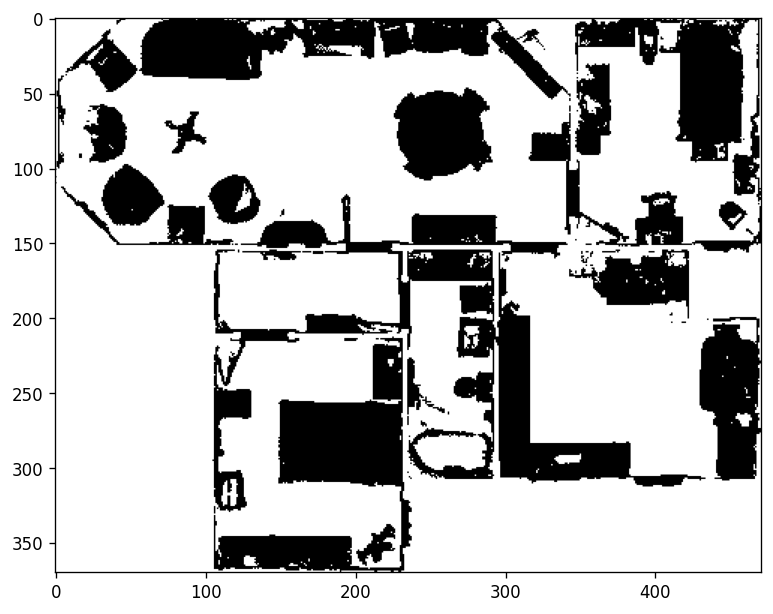

In [17]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
#print(obstacles)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

you can see that the obstacles are black and the free space is white. You can also observe noisy black points lying on the ground. These points are caused by the slope or different floor heights in the scene.

## Show Top-Down Color Map

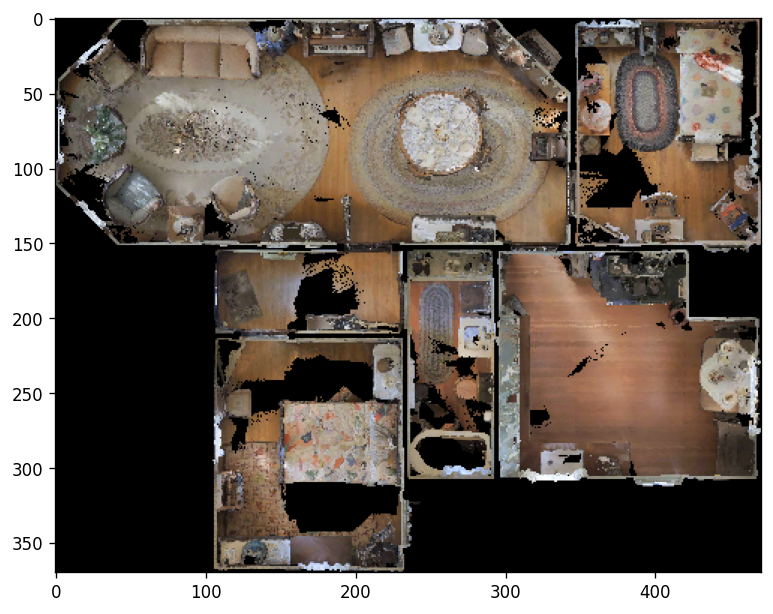

In [18]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.show()


the color map is created by projecting the color-augmented point cloud to the floor.

## Show Landmark Indexing Results

In [19]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
# clip_version = "ViT-B/32"
# clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
#                 'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
# clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
# clip_model.to(device).eval()

In [20]:
grid = load_map(grid_save_path)
print(grid.shape)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid.shape)
print(grid_save_path)
print(grid[100,100].keys())

(2000, 2000)
(370, 471)
/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2/map/grid_lseg_dummy_geo_dist4_reverse3_4llava_wall4.npy
dict_keys([490])


In [21]:
background_grid = load_map(background_grid_save_path)
background_grid = background_grid[xmin:xmax+1, ymin:ymax+1]
print(background_grid.shape)
bbackground_grid = np.zeros_like(background_grid)
bbackground_grid[background_grid == 1] = 2
bbackground_grid[background_grid == 2] = 1

(370, 471)


we use the text form of all semantic categories provided by the Matterport3D dataset as prompts to the VLMap and localize all categories in the map. We filter out "floor" category.

In [22]:
# weight = load_map(weight_save_path)
# weight = weight[xmin:xmax+1, ymin:ymax+1]
# print(weight.shape)
# np.savetxt('data_weight.txt', weight, fmt='%3d', delimiter=',')

In [23]:
# #obstacles=obstacles[xmin:xmax+1, ymin:ymax+1]
# print(obstacles.shape)
# np.savetxt('data_obstacles.txt', obstacles, fmt='%3d', delimiter=',')
# print(obstacles)

In [24]:
# query = ["void","table in the kitchen"]
query = [
    "void",
    "wall",
    "floor",
    "chair",
    "door",
    "table",
    "picture",
    "cabinet",
    "cushion",
    "window",
    "sofa",
    "bed",
    "curtain",
    "chest_of_drawers",
    "plant",
    "sink",
    "stairs",
    "ceiling",
    "toilet",
    "stool",
    "towel",
    "mirror",
    "tv_monitor",
    "shower",
    "column",
    "bathtub",
    "counter",
    "fireplace",
    "lighting",
    "beam",
    "railing",
    "shelving",
    "blinds",
    "gym_equipment",
    "seating",
    "board_panel",
    "furniture",
    "appliances",
    "clothes",
    "objects",
    # "carpet"
]
# query = [
#     "void",
#     "wall",
#     "floor",
#     "chair",
#     "door",
#     "table",
#     "picture",
#     "cabinet",
#     "cushion",
#     "window",
#     "sofa",
#     "bed",
#     "curtain",
#     "sink",
#     "stairs"
# ]

# query = [
#     "void",
# #    "floor",
#     "bed_room in a scene"
# ]
t_emb = model.encode_prompt(query, task="default")

aa = t_emb.cpu().numpy()
print(aa.shape)

# query = ["table","computer"]
# t_emb = model.encode_prompt(query, task="default")
# aa = t_emb.cpu().numpy()

# print(aa.shape)

# qq = ["computer on the table"]
# tt = model.encode_prompt(qq, task="default")
# bb = tt.cpu().numpy()



(40, 512)


In [25]:
import pickle


embeddings_path = os.path.join(data_dir, f"map/instance_dict_{mask_version}.pkl")
print(embeddings_path)



#"/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2_mini/map/instance_dict_dummy_geo_dist4.pkl"

with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0

/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2/map/instance_dict_dummy_geo_dist4_reverse3_4llava_wall4.pkl


(370, 471)
embeddings: 236
(370, 471)


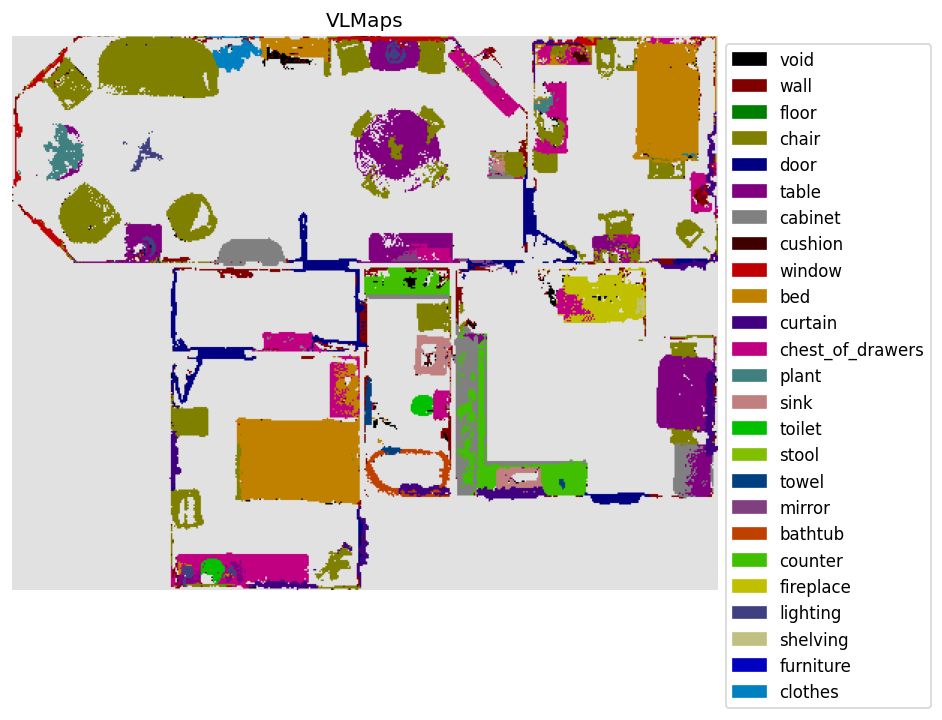

In [31]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)
# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
ggrid_map[background_grid == 1] = 2
ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                # if max_height > candidate_height:
                #     max_height = candidate_height
                #     candidate_val = candidate
                if candidate_observed > max_observed:
                    max_observed = candidate_observed
                    candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
print(ggrid_map.shape)
np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

(370, 471)
embeddings: 236


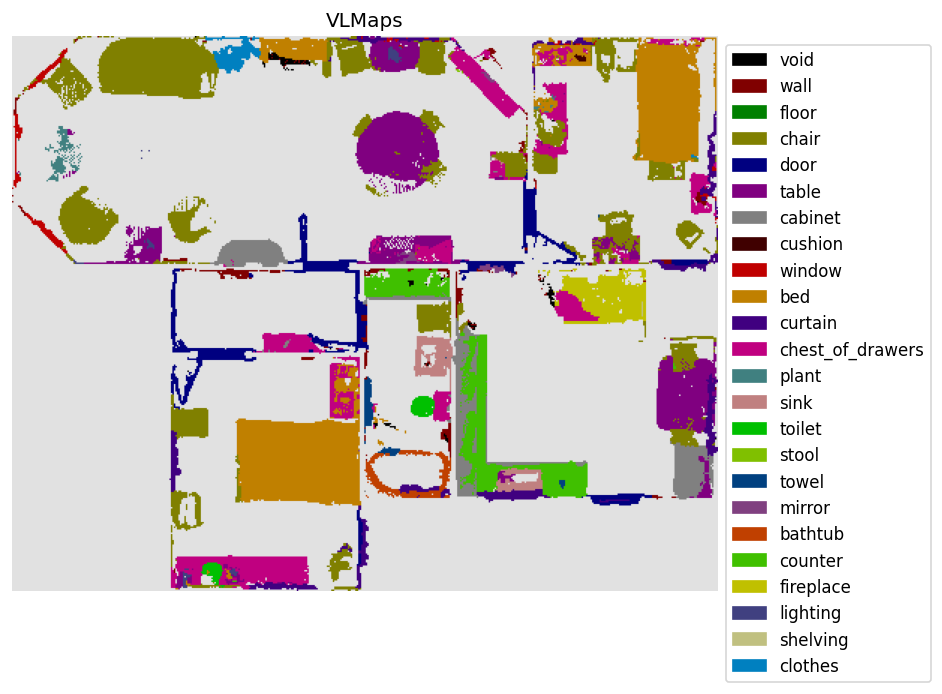

In [27]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)
# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.empty_like(grid, dtype=dict)
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        ggrid_map[i,j] = {}
        
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        # if len(grid[i,j].keys()) == 1:
        #     # print(grid[i,j][0])
        for key in grid[i,j].keys():
            new_key = predicts[list(embeddings.keys()).index(key)]
            ggrid_map[i,j][new_key] = grid[i,j][key][2]
                # ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        # else:
        #     max_conf = 0
        #     max_height = 0
        #     # candidate_val = 0
        #     for key, val in grid[i,j].items():
        #         # print(arg)
        #         # print(predicts.shape)
        #         candidate = predicts[list(embeddings.keys()).index(key)]
        #         candidate_conf = val[0]
        #         candidate_height = val[2]
        #         # if max_conf < candidate_conf:
        #         #     max_conf = candidate_conf
        #         #     candidate_val = candidate
        #         if max_height < candidate_height:
        #             max_height = candidate_height
        #             candidate_val = candidate
        #     ggrid_map[i,j] = candidate_val

center_weight = 3
gggrid_map = np.zeros_like(ggrid_map, dtype=np.uint8)
gggrid_map[background_grid == 1] = 2
gggrid_map[background_grid == 2] = 1
grid_upper = np.empty((ggrid_map.shape[0]+1, ggrid_map.shape[1]+1), dtype=dict)
for i in range(ggrid_map.shape[0]+1):
    for j in range(ggrid_map.shape[1]+1):
        grid_upper[i,j] = {}
grid_upper[1:,1:] = ggrid_map
for i in range(1,gggrid_map.shape[0]+1):
    for j in range(1,gggrid_map.shape[1]+1):
        candidate = grid_upper[i-1:i+2,j-1:j+2]
        item_dict = {}
        for candidate_i in range(candidate.shape[0]):
            for candidate_j in range(candidate.shape[1]):
                if candidate_i == i and candidate_j == j:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += center_weight #* val
                        else: item_dict[key] = center_weight #* val
                else:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += 1 #* val
                        else: item_dict[key] = 1 #*  val
        if len(item_dict) ==0:
            # gggrid_map[i-1,j-1] = 0
            continue
        max_key = max(item_dict, key=item_dict.get)
        if max_key == 0 : continue
        gggrid_map[i-1,j-1] = max_key


floor_mask = gggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(gggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
gggrid_map_save_path = os.path.join(map_save_dir, f"gggrid_{mask_version}.npy")
np.save(gggrid_map_save_path, gggrid_map)
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

In [28]:
temp1 = 15
temp2 = 5

temp1_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
temp2_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# temp1_feat = instance_feat[temp1]

temp1_feat = embeddings[temp1]["embedding"]
temp1_mask = embeddings[temp1]["mask"]
temp1_feat = temp1_feat / np.linalg.norm(temp1_feat)
# temp2_feat = instance_feat[temp2]
temp2_feat = embeddings[temp2]["embedding"]
temp2_mask = embeddings[temp2]["mask"]
temp2_feat = temp2_feat / np.linalg.norm(temp2_feat)


print(f"Size: {np.sum(temp1_mask)} {np.sum(temp2_mask)}")


semSim = temp1_feat @ temp2_feat.T
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if temp1 in grid[i,j]:
            temp1_map[i,j] = 1
        if temp2 in grid[i,j]:
            temp2_map[i,j] = 1
print(f"size2: {np.sum(temp1_map)} {np.sum(temp2_map)}")
union_map = np.logical_or(temp1_map, temp2_map).astype(int)
intersection_map = np.logical_and(temp1_map, temp2_map).astype(int)

uu=np.logical_or(temp1_mask, temp2_mask).astype(int)
ii=np.logical_and(temp1_mask, temp2_mask).astype(int)
iiou = np.sum(ii) / np.sum(uu)
print(f"IIoU: {iiou:.3f} (for checking the mask is correct)")


iou = np.sum(intersection_map) / np.sum(union_map)


temp1_center = np.argwhere(temp1_map == 1).mean(axis=0)
temp2_center = np.argwhere(temp2_map == 1).mean(axis=0)
center_dist = np.linalg.norm(temp1_center - temp2_center)

temp1_bbox = calculate_bbox(temp1_map)
temp2_bbox = calculate_bbox(temp2_map)
iou_bbox = calculate_iou_bbox(temp1_bbox, temp2_bbox)


print(f"Center Point : temp1 {temp1_center}, temp2 {temp2_center}")
print(f"bbox IoU: {iou_bbox:.3f}")
print(f"IoU: {iou:.3f}, Center Distance: {center_dist:.3f}")
print(f"Cosine Similarity: {semSim}")

contours1, _ = cv2.findContours(temp1_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(temp2_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


lengths1 = [len(contour) for contour in contours1]
if len(contours1) == 0:
    raise Exception("no contour")
contour1 = contours1[np.argmax(lengths1)].squeeze(axis=1)
lengths2 = [len(contour) for contour in contours2]
contour2 = contours2[np.argmax(lengths2)].squeeze(axis=1)
haus12 = directed_hausdorff(contour1, contour2)[0]
haus21 = directed_hausdorff(contour2, contour1)[0]
hausdorff_distance = (haus12 + haus21) / 2
print(f"Hausdorff Distance: {hausdorff_distance}")

KeyError: 15

dict_keys([0, 1, 2, 5, 9, 17, 19, 27, 28, 29, 33, 34, 35, 37, 39, 47, 50, 52, 56, 58, 61, 64, 69])
bed
(193, 220)
3177


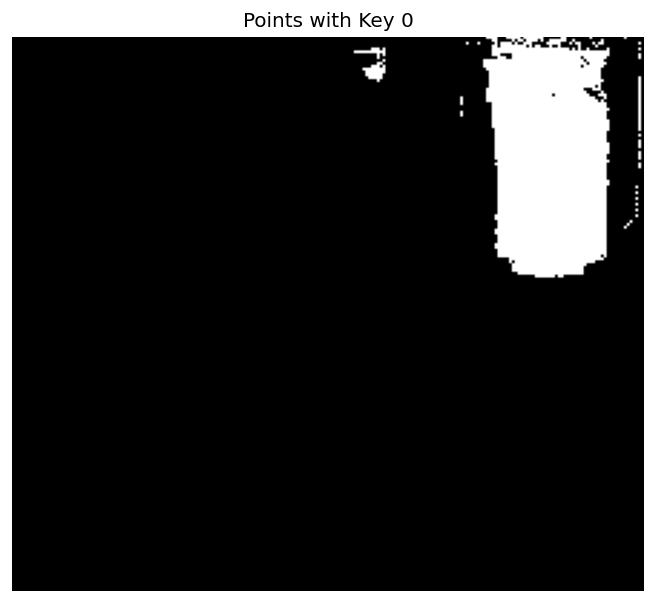

chest_of_drawers
(193, 220)
215


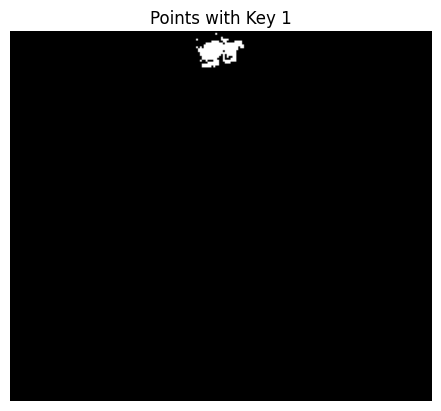

curtain
(193, 220)
525


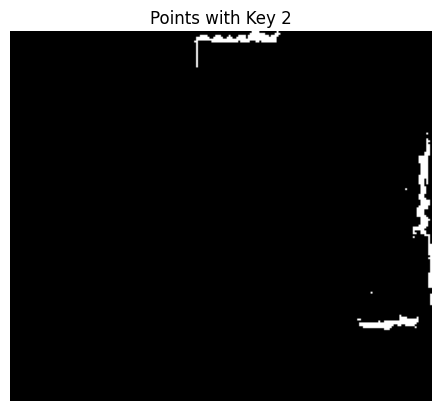

chair
(193, 220)
150


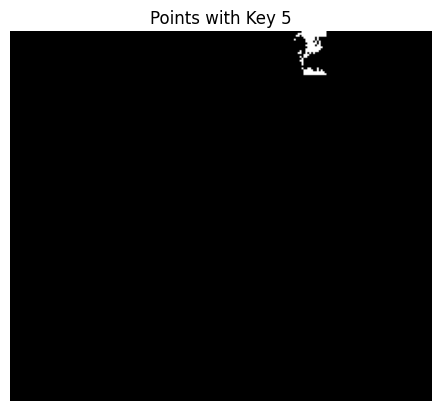

chair
(193, 220)
267


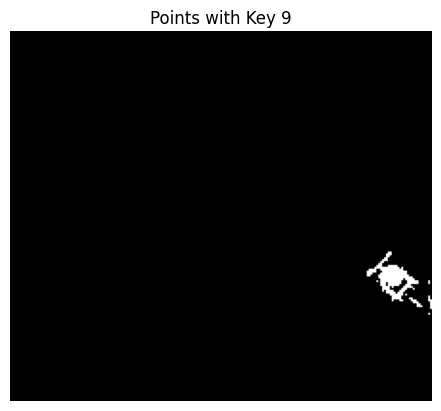

chair
(193, 220)
321


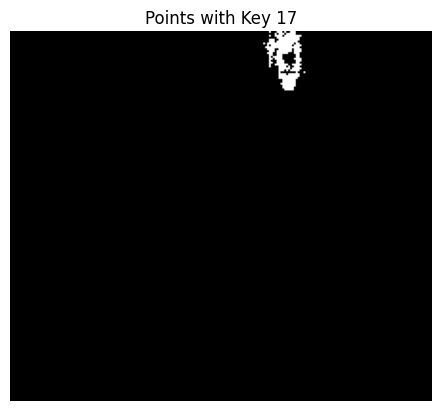

bed
(193, 220)
911


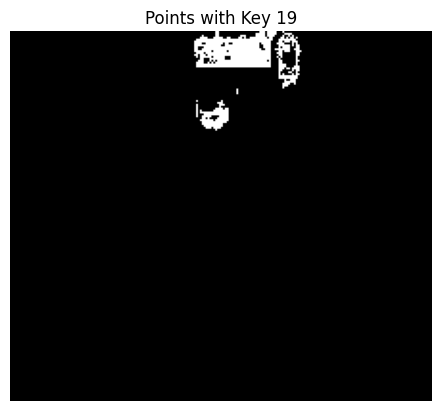

plant
(193, 220)
169


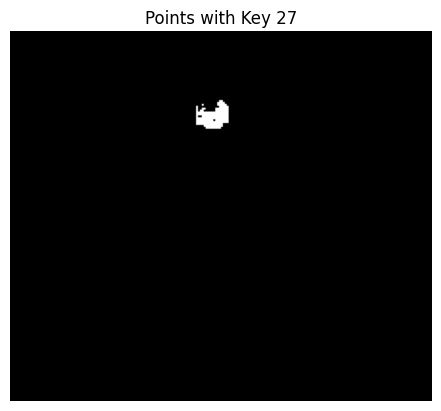

floor
(193, 220)
2394


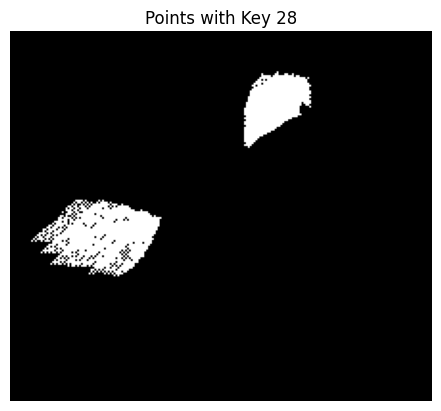

chest_of_drawers
(193, 220)
579


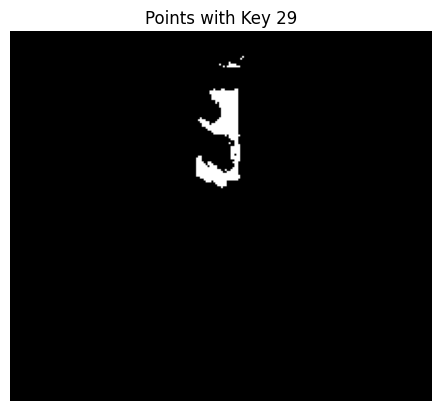

chair
(193, 220)
223


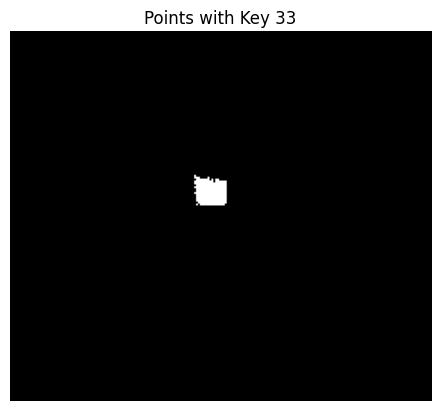

chair
(193, 220)
159


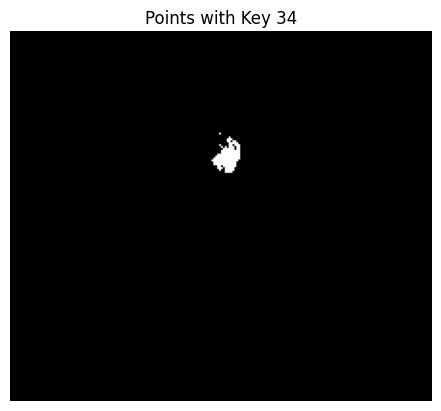

door
(193, 220)
375


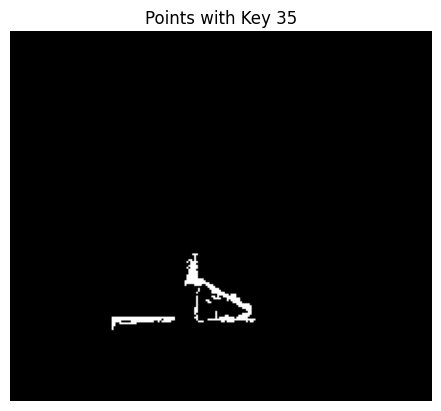

window
(193, 220)
153


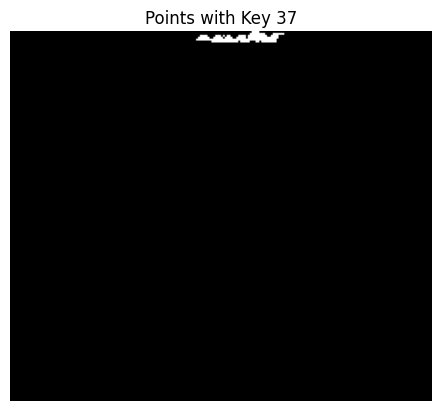

table
(193, 220)
382


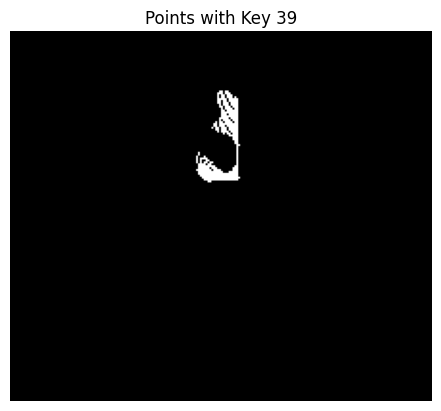

chest_of_drawers
(193, 220)
332


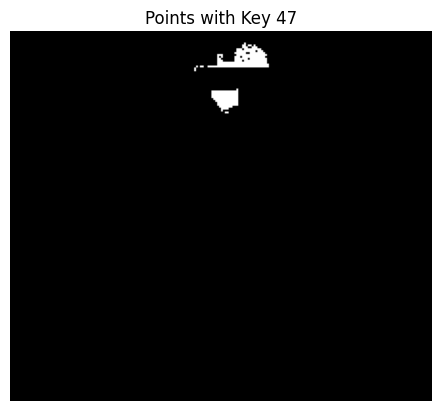

curtain
(193, 220)
132


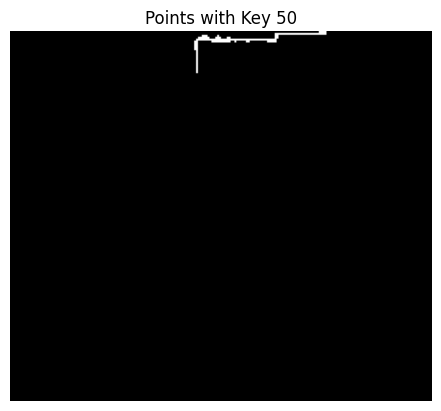

chest_of_drawers
(193, 220)
170


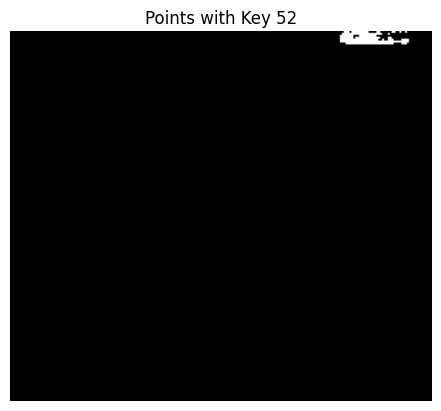

chair
(193, 220)
379


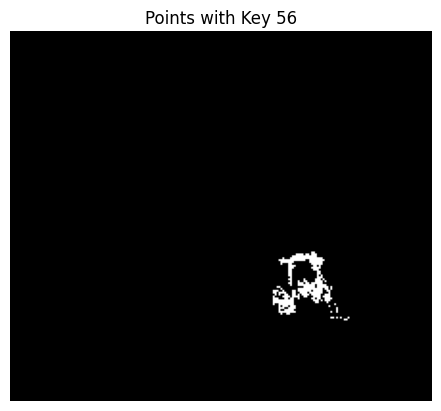

chair
(193, 220)
126


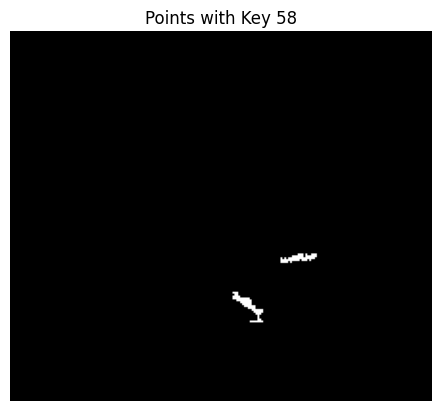

table
(193, 220)
460


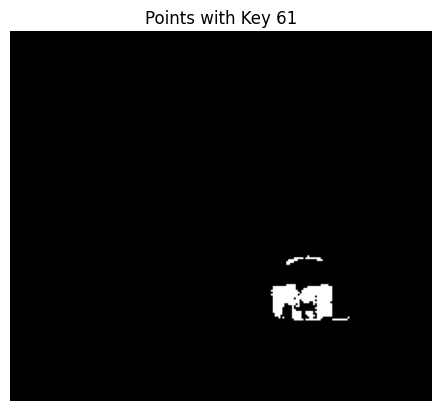

curtain
(193, 220)
105


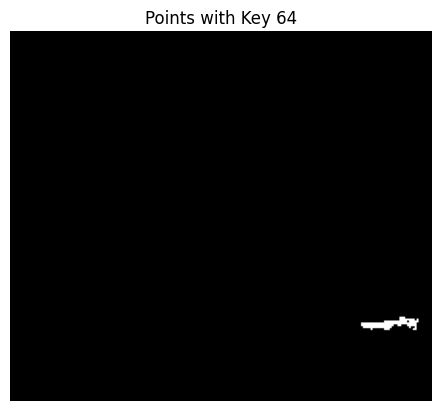

chest_of_drawers
(193, 220)
252


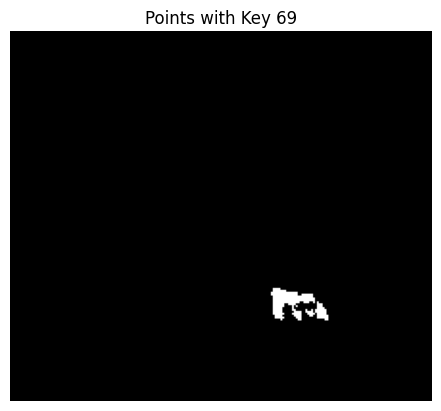

In [29]:
# # 좌표에 0이 키값으로 있는 포인트만 선택하여 ggrid_map 생성
# ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         if 5 in grid[i, j]:
#             ggrid_map[i, j] = 1  # 0 키를 가진 포인트는 1로 표시

# # 시각화를 위해 1이 있는 곳만 표시
# plt.figure(figsize=(10, 6), dpi=120)
# plt.imshow(ggrid_map, cmap="gray")
# plt.axis('off')
# plt.title("Points with Key 0")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# 시각화를 위한 설정
plt.figure(figsize=(10, 6), dpi=120)
print(embeddings.keys())
# k값을 0부터 287까지 변경하면서 시각화
for n,id in enumerate(embeddings.keys()):
    # 좌표에 k가 키값으로 있는 포인트만 선택하여 ggrid_map 생성
    ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if id in grid[i, j]:
                ggrid_map[i, j] = 1  # k 키를 가진 포인트는 1로 표시
    # maskk = embeddings[id]["mask"]
    # print(maskk.shape)
    # print(np.sum(maskk))
    # # 시각화를 위해 1이 있는 곳만 표시
    # plt.clf()  # 이전 이미지 지우기
    # plt.imshow(maskk, cmap="gray")

    plt.clf()  # 이전 이미지 지우기
    name = predicts[n]
    print(query[name])
    print(ggrid_map.shape)
    print(np.sum(ggrid_map))
    plt.imshow(ggrid_map, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()

-----------

In [ ]:

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)


map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ aa.T

predicts = np.argmax(scores_list, axis=1)



for r in range(len(scores_list)):
    if max(scores_list[r]) < 15:
        if predicts[r] == 0:
            continue
        print("asfasfdsafs")
        print(max(scores_list[r]))
        predicts[r] = 0



predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2
print(predicts.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 512 is different from 471)

## Open-Vocabulary Landmark Indexing

In addition to using the fixed set of categories, we can also use customized text prompts to the map and index their corresponding locations. You could play around with the `lang` variable below by providing your own prompt. 

In [ ]:
# @markdown Input the prompt as a string of object names separated by ","
lang = "big flat counter, sofa, floor, chair, wash basin, other" # @param {type: "string"}
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

NameError: name 'clip_model' is not defined

# Object Goal

In [ ]:
%matplotlib inline
from copy import deepcopy
import os
from openai import OpenAI
from vlmaps.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from vlmaps.utils.clip_utils import get_text_feats
import torch
from vlmaps.utils.mp3dcat import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip
from numpy.typing import NDArray
from typing import List, Tuple, Any, Union
# for get robot start position randomly
import random
# for visualizer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# for get position, noise remove
from scipy.ndimage import binary_closing,binary_opening, binary_dilation, gaussian_filter
# for get goal position
from shapely.geometry import Point, Polygon
# for path finding
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

## LLM

In [ ]:
#
#* LLM 처리 함수

client = OpenAI(api_key=os.environ['OPENAI_KEY'])
openai_models=["gpt-3.5-turbo-instruct",
                "davinci-002",
                "text-embedding-3-large", # 못쓴다함
                "babbage-002",
                "gpt-4"]
openai_model=openai_models[0]

def parse_object_goal_instruction(language_instr):
    question = f"""
    I: go to the kitchen and then go to the toilet. A: kitchen, toilet
    I: go to the chair and then go to another chair. A: chair, chair
    I: navigate to the green sofa and turn right and find several chairs, finally go to the painting. A: green sofa, chairs, painting
    I: approach the window in front, turn right and go to the television, and finally go by the oven in the kitchen. A: window, television, oven, kitchen
    I: walk to the plant first, turn around and come back to the table, go further into the bedroom, and stand next to the bed. A: plant, table, bedroom, bed
    I: go by the stairs, go to the room next to it, approach the book shelf and then go to the table in the next room. A: stairs, room, book shelf, table, next room
    I: Go front left and move to the table, then turn around and find a cushion, later stand next to a column before finally navigate to any appliances. A: table, cushion, column, appliances.
    I: Move to the west of the chair, with the sofa on your right, move to the table, then turn right 90 degree, then find a table. A: chair, table
    I: {language_instr}. A:"""
    response = client.completions.create(model=openai_model, prompt=question, max_tokens=64, temperature=0.0)
    result = response.choices[0].text.strip()
    return [x.strip() for x in result.split(",")] #* 목표 키워드들의 리스트가 반환! spatial과는 다르게 키워드만 반환되고, 밖에서 target으로 이동시키는 함수에 해당 키워드가 들어가 이동

## Navigation - get init robot point (randomly)

- 랜덤하게 floor 인덱스인 픽셀 중 하나 뽑아 사용

In [ ]:
def init_robot_pos(vlmap: NDArray[int], labels: List[str]) -> List[int]:#Tuple[int, int]:
    floor_id = labels.index("floor")
    while True:
        rand_x=random.randint(0, vlmap.shape[0]-1)
        rand_y=random.randint(0, vlmap.shape[1]-1)
        if vlmap[rand_x, rand_y] == floor_id:
            return [rand_x, rand_y]
def init_robot_pos2(obs_map: NDArray[int], ind: int) -> List[int]:
    while True:
        rand_x=random.randint(0, obs_map.shape[0]-1)
        rand_y=random.randint(0, obs_map.shape[1]-1)
        if obs_map[rand_x, rand_y] == ind:
            return [rand_x, rand_y]

## Navigation - get goal point

- visualizer

In [ ]:
def visualizer(map: NDArray[np.int_], labels: Union[List[str], None]=None):
    if labels:
        new_pallete = get_new_pallete(len(labels))
        mask, patches = get_new_mask_pallete(map, new_pallete, out_label_flag=True, labels=labels)
        seg = mask.convert("RGBA")
        seg = np.array(seg)
        seg = Image.fromarray(seg)
        plt.figure(figsize=(10, 6), dpi=120)
        plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
        plt.axis('off')
        plt.title("Visualized Map")
        plt.imshow(seg)
        plt.show()
        return

    if map.dtype != np.bool_:
        map = map.astype(np.bool_)

    # 데이터 타입을 uint8로 지정하면서 255를 곱함
    hong_vis = Image.fromarray((map * 255).astype(np.uint8))

    plt.figure(figsize=(8, 6), dpi=120)
    plt.imshow(hong_vis, cmap='gray')
    plt.axis('off')
    plt.show()

- get pos function

In [ ]:
# name의 object만 True로 하는 mask를 만들어 해당 object의 center, contour, bbox를 반환
# name에는 리스트로 여러 object를 넣을 수 있고 obstacle_map를 True로 주어 name을 제외한 나머지에 대한 마스크를 만들어 마스크만 반환할 수 있음(obstacle map 만들 때 사용)
#* foreground 자체는 해당 obstacle이 있을 때 true, obstacle_map을 true로 주면 val은 1-foreground로, obstacle이 없는 곳이 1이 되게 됨
def get_pos(vlmap: NDArray[np.int32], name: Union[str,List[str]], labels: List[str], obstacle_map: bool = False) -> Tuple[List[List[int]], List[List[float]], List[np.ndarray], Any]:
    """
    Get the contours, centers, and bbox list of a certain category
    on a full map
    """
    if obstacle_map:
        idxs = [labels.index(n) for n in labels if n not in name]
    else:
        if type(name)==str:
            idx = labels.index(name)
            idxs=[idx]
        else:
            idxs = [labels.index(n) for n in name]
    item_mask = np.isin(vlmap, idxs)
    visualizer(item_mask)
    foreground = binary_closing(item_mask, iterations=3) #* 이진 이미지에 적용되며, 이미지 내의 작은 구멍을 채우고 전경 객체의 작은 돌출 부분을 부드럽게 하는 데 사용
    #! 여기 원래 sigma 값은 0.8, 아래의 threshold 값은 0.5였는데 노이즈 없애려고 크게 잡음
    foreground = gaussian_filter(foreground.astype(float), sigma=2, truncate=3)#sigma=0.8, truncate=3) 
    foreground = foreground > 0.8#0.5 #! 여기 그 성능 개선 요소
    
    foreground = binary_dilation(foreground)
    if obstacle_map:
        val=1-foreground
        return val
    contours, centers, bbox_list, _ = get_segment_islands_pos(foreground, 1) #* item_mask 값이 1인 즉, 해당 객체가 위치하는 곳들에 대해 center, contour, bbox를 반환
    return contours, centers, bbox_list



def get_segment_islands_pos(segment_map: Union[NDArray[np.bool_], NDArray[np.int32]], label_id: int, detect_internal_contours: bool =False) -> Tuple[List[np.ndarray], List[Tuple[int, int]], List[List[int]], Any]:
    mask = segment_map == label_id
    mask = mask.astype(np.uint8)
    detect_type = cv2.RETR_EXTERNAL
    if detect_internal_contours:
        detect_type = cv2.RETR_TREE

    contours, hierarchy = cv2.findContours(mask, detect_type, cv2.CHAIN_APPROX_SIMPLE)
    # convert contours back to numpy index order
    contours_list = []
    for contour in contours:
        tmp = contour.reshape((-1, 2))
        tmp_1 = np.stack([tmp[:, 1], tmp[:, 0]], axis=1)
        contours_list.append(tmp_1)

    centers_list = []

    bbox_list = []
    for c in contours_list:
        xmin = np.min(c[:, 0])
        xmax = np.max(c[:, 0])
        ymin = np.min(c[:, 1])
        ymax = np.max(c[:, 1])
        bbox_list.append([xmin, xmax, ymin, ymax])

        centers_list.append([(xmin + xmax) / 2, (ymin + ymax) / 2])

    visualizer(mask)

    return contours_list, centers_list, bbox_list, hierarchy

#contours,centers,bbox_list = get_pos(predicts,"table",lang)


In [ ]:
def get_nearest_pos(vlmap: NDArray[np.int32], curr_pos: Tuple[int,int], name: str, labels: List[str]) -> Tuple[float, float]:
    contours, centers, bbox_list = get_pos(vlmap,name,labels)
    ids_list = filter_small_objects(bbox_list, area_thres=100)
    contours = [contours[i] for i in ids_list]
    centers = [centers[i] for i in ids_list]
    bbox_list = [bbox_list[i] for i in ids_list]
    if len(centers) == 0: 
        print("warning") #* 해당 객체가 없다는 것이니 이 경우엔 정말 없는지 확인 필요하므로
        return curr_pos 
    id = select_nearest_obj(centers, bbox_list, curr_pos)
    print(len(contours))
    return nearest_point_on_polygon(curr_pos, contours[id], centers[id])


def get_nearest_pos4direct(goal_mask: NDArray[int], curr_pos: List[int]) -> Tuple[float, float]:
    contours, centers, bbox_list, _ = get_segment_islands_pos(goal_mask, 1)
    ids_list = filter_small_objects(bbox_list, area_thres=100)
    contours = [contours[i] for i in ids_list]
    centers = [centers[i] for i in ids_list]
    bbox_list = [bbox_list[i] for i in ids_list]
    if len(centers) == 0: 
        print("warning") #* 해당 객체가 없다는 것이니 이 경우엔 정말 없는지 확인 필요하므로
        return curr_pos 
    id = select_nearest_obj(centers, bbox_list, curr_pos)
    print(len(contours))
    return nearest_point_on_polygon(curr_pos, contours[id], centers[id])


# 작은 island들은 제거하는 함수 #! 성능 개선 요소
def filter_small_objects(bbox_list: List[List[int]], area_thres: int = 50) -> List[int]:
    results_ids = []
    # print("before filtering")
    # print(len(bbox_list))
    for bbox_i, bbox in enumerate(bbox_list):
        dx = bbox[1] - bbox[0]
        dy = bbox[3] - bbox[2]
        area = dx * dy
        # print(dx,dy,area)
        if area > area_thres:
            results_ids.append(bbox_i)
    # print("after filtering")
    # print(len(results_ids))
    return results_ids


# 여러 island 중에서 가장 가까운 island 선택 함수
def select_nearest_obj(
    centers: List[List[float]],
    bbox_list: List[List[float]],
    curr_pos: Tuple[float, float],
) -> int:
    dist_list = []
    #print(len(bbox_list))
    for c, bbox in zip(centers, bbox_list):
        size = np.array([bbox[1] - bbox[0], bbox[3] - bbox[2]])
        dist = get_dist_to_bbox_2d(np.array(c), size, np.array(curr_pos))
        dist_list.append(dist)
    #print(len(dist_list))
    id = np.argmin(dist_list)
    return id


# 대각선, 좌우, 상하의 경우로 나누어 각각의 경우에 대한 로봇으로부터 island까지의 거리를 계산해 반환
def get_dist_to_bbox_2d(center: NDArray[np.float32], size: NDArray[np.int32], pos: NDArray[int]) -> float:
    min_corner_2d, max_corner_2d = get_bbox(center, size)

    dx = pos[0] - center[0]
    dy = pos[1] - center[1]

    if pos[0] < min_corner_2d[0] or pos[0] > max_corner_2d[0]:
        if pos[1] < min_corner_2d[1] or pos[1] > max_corner_2d[1]:
            """ case1 : 대상의 대각선 방향에 로봇이 위치한 경우
            star region
            *  |  |  *
            ___|__|___
               |  |
            ___|__|___
               |  |
            *  |  |  *
            """

            dx_c = np.abs(dx) - size[0] / 2
            dy_c = np.abs(dy) - size[1] / 2
            dist = np.sqrt(dx_c * dx_c + dy_c * dy_c)
            return dist
        else:
            """ case2 : 대상의 좌우 방향에 로봇이 위치한 경우
            star region
               |  |
            ___|__|___
            *  |  |  *
            ___|__|___
               |  |
               |  |
            """
            dx_b = np.abs(dx) - size[0] / 2
            return dx_b
    else:
        if pos[1] < min_corner_2d[1] or pos[1] > max_corner_2d[1]:
            """ case3 : 대상의 상하 방향에 로봇이 위치한 경우
            star region
               |* |
            ___|__|___
               |  |
            ___|__|___
               |* |
               |  |
            """
            dy_b = np.abs(dy) - size[1] / 2
            return dy_b
        """ case4 : 대상의 내부에 로봇이 위치한 경우 (오류)
        star region
           |  |  
        ___|__|___
           |* |   
        ___|__|___
           |  |   
           |  |  
        """
        return 0
    

# center, size로 bbox의 min corner, max corner를 반환하는 함수
def get_bbox(center: NDArray[np.float32], size: NDArray[np.int32]):
    """
    Return min corner and max corner coordinate
    """
    min_corner = center - size / 2
    max_corner = center + size / 2
    return min_corner, max_corner


# 가장 가까운 island에서도 로봇과 가장 가까운 점을 찾는 함수
def nearest_point_on_polygon(coord: Tuple[int, int], polygon: List[List[float]], center: List[float]) -> Tuple[float, float]:
    # Create a Shapely Point from the given coordinate
    point = Point(coord)
    # Create a Shapely Polygon from the polygon's coordinates
    poly = Polygon(polygon)
    # Find the nearest point on the polygon's boundary to the given point
    nearest = poly.exterior.interpolate(poly.exterior.project(point))
    # Extract the nearest point's coordinates as a tuple
    nearest_coords = (int(nearest.x), int(nearest.y))
    # if nearest_coords[0]<center[0]:
    #     if nearest_coords[1]<center[1]:
    #         nearest_coords=(nearest_coords[0]-1,nearest_coords[1]-1)
    #     else: nearest_coords=(nearest_coords[0]-1,nearest_coords[1]+1)
    # else:
    #     if nearest_coords[1]<center[1]:
    #         nearest_coords=(nearest_coords[0]+1,nearest_coords[1]-1)
    #     else: nearest_coords=(nearest_coords[0]+1,nearest_coords[1]+1)




    print(polygon)
    # # 시각화
    # for x,y in polygon:
    #     print(x,y)
    print("goal", nearest_coords)
    print("robot", coord)
    x, y = zip(*polygon)  # 다각형을 닫기 위해 시작점을 다시 추가
    plt.plot(x, y, 'r-o', label='Polygon')  # 빨간 선으로 다각형 표시
    # 원래 점 표시
    # 가장 가까운 점 표시
    plt.plot(*nearest_coords, 'gx', label='Nearest Point on Polygon')
    plt.plot(*coord, 'gx', label='Nearest Point on Polygon')
    # 레이블 및 범례 추가
    plt.legend()
    # 그리드 및 범위 설정
    # plt.xlim(190, 250)
    # plt.ylim(160, 370)
    plt.grid(True)
    plt.show()

#    raise Exception("stop")








    return nearest_coords

#goal_point = get_nearest_pos(predicts,robot_point,"table",5)
#print(goal_point)

- **robot, goal point 시각화** (작은 하얀 점이 robot, 큰 하얀 점이 goal)

In [ ]:
def robot_goal_visualizer(vlmap: NDArray[np.int32], robot_point: Tuple[int,int], goal_point: Tuple[int,int], labels: List[str]):
    goal_point_x=goal_point[0]
    goal_point_y=goal_point[1]

    new_pallete = get_new_pallete(len(labels))
    mask, patches = get_new_mask_pallete(vlmap, new_pallete, out_label_flag=True, labels=labels)
    seg = mask.convert("RGBA")
    seg = np.array(seg)
    seg[robot_point[0]-2:robot_point[0]+2, robot_point[1]-2:robot_point[1]+2] = [225, 225, 225, 255]
    seg[goal_point_x-3:goal_point_x+3, goal_point_y-3:goal_point_y+3] = [0,0,0, 0]
    seg = Image.fromarray(seg)
    plt.figure(figsize=(10, 6), dpi=120)
    plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
    plt.axis('off')
    plt.title("robot and goal")
    plt.imshow(seg)
    plt.show()

## Navigation - check goal position

- goal position을 뽑는 VLMap과 경로 탐색이 이루어지는 obstacle map이 따로 존재하고 디노이징 과정에서 둘의 장애물 형태가 달라지면서 goal position이 obstacle map에서는 장애물 내에 존재하는 상황 발생
  - `check_goal` 함수를 통해 문제 해결 (대충 짠거라 좋은 방법은 아니라 생각) (근데 추후에는 다른 방법으로 개선해야 될 듯 둘의 장애물 형태가 다른 것 자체가 정확도가 낮은 것을 의미하는 것이니)
    - goal position 주변 좌우상하 d_half (즉, dxd크기 matrix)만큼을 obstacle map에서 봄
    - goal position 바로 주변에 1(이동가능함을 표시하는 인덱스)이 있으면 연결된 길이 있다고 판단해 goal position을 변경하지 않고 반환 (근데 너무 논리적 비약이라 고쳐야될 듯 나중에)
    - 주변이 0으로 막혀있다면 dxd크기의 matrix에서 1을 갖는 좌표들마다 goal position까지의 거리를 계산해 최단 거리를 갖는 좌표를 goal_position으로 반환
- 기존에는 객체 center와 위치 비교를 해서 goal position을 이동시킬까 했는데 객체 모양이 정사각형이 아니라 한쪽으로 길쭉하거나 여러 형태가 있으니 이 방법은 적절하지 못하다고 판단해서 위의 방식으로 진행

In [ ]:
def check_goal_manhattan_distance(pos1, pos2):
    return np.abs(pos1[0] - pos2[0]) + np.abs(pos1[1] - pos2[1])

def check_goal(obstacle_map: NDArray[int], goal_pos: Tuple[float,float],d_half: int = 15) -> Tuple[float,float]:
    d=2*d_half+1
    check_map=obstacle_map[goal_pos[0]-d_half:goal_pos[0]+d_half+1, goal_pos[1]-d_half:goal_pos[1]+d_half+1]
    if 1 in obstacle_map[goal_pos[0]-1:goal_pos[0]+1, goal_pos[1]-1:goal_pos[1]+1]: #* contour 상인지 확인
        print("Not changed!!!!!!!!!!!!!!!!!!!!!!1")
        print(obstacle_map[goal_pos[0]-15:goal_pos[0]+16, goal_pos[1]-15:goal_pos[1]+16])
        visualizer(obstacle_map[goal_pos[0]-100:goal_pos[0]+101, goal_pos[1]-100:goal_pos[1]+101])
        return goal_pos
    return_pos = None
    print(obstacle_map[goal_pos[0]-5:goal_pos[0]+6, goal_pos[1]-5:goal_pos[1]+6])
    dist_min=10000
    for r in range(d):
        for c in range(d):
            #print(check_map.shape)
            #print(r,c)
            if check_map[r,c]==1:
                dist = check_goal_manhattan_distance((r,c),(5,5))
                if dist<dist_min:
                    dist_min=dist
                    #kya=(r,c)
                    return_pos=(goal_pos[0]-d_half+r,goal_pos[1]-d_half+c)
    #check_map[kya]=9
    #print(check_map)
    #obstacle_map[return_pos]=9
    #print(return_pos)
#    print(obstacle_map[return_pos])
    print(obstacle_map[return_pos[0]-15:return_pos[0]+16, return_pos[1]-15:return_pos[1]+16])
    visualizer(obstacle_map[return_pos[0]-100:return_pos[0]+101, return_pos[1]-100:return_pos[1]+101])
    return return_pos

## Navigation - pathfinding

- 일단 A*와 BFS(너비우선탐색) 둘 중에서만 선택할 수 있음
  - 성능은 둘끼리 비슷한 것 같은데 흠

In [ ]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.breadth_first import BreadthFirstFinder
def pathfinder(obs_map: NDArray[np.int32], robot_point: Tuple[int, int],goal_point: Tuple[float, float]) -> List[Tuple[int, int]]:
    obs_map = deepcopy(obs_map)
    grid = Grid(matrix=obs_map)#, inverse=True)
    print(grid)
    print(robot_point,goal_point)
    # 시작점과 종점 정의
    #*y,x반전!!
    start = grid.node(robot_point[1], robot_point[0]) 
    end = grid.node(goal_point[1], goal_point[0])
    print(start,end)

    #* pathfinding 알고리즘 선택!
    #finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
    finder = BreadthFirstFinder(diagonal_movement=DiagonalMovement.never)


    # 경로 찾기
    path, runs = finder.find_path(start, end, grid)

    print("Operations used:", runs)
    print("Path:", path)
    #print(grid.grid_str(path=path, start=start, end=end))
    for point in path:
        obs_map[point.y, point.x] = 2  # 경로를 '2'로 표시
    visualizer(obs_map, ["obstacle","floor","path"])
    # 시각화
    # plt.figure(figsize=(8, 8))
    # plt.imshow(path_map, cmap='hot', interpolation='nearest')
    # plt.colorbar()
    # plt.title('Visualized Path on Map')
    # plt.show()
    return path




## Navigation - get mask from VLMap directly

- `get_mask_from_vlmap` : vlmap에서 goal mask나 obstacle map 등을 뽑을 때 쓰는 함수로, 입력 받은('name'에 해당되는) 객체와 void만의 코사인유사도 행렬을 구해 둘만의 마스크 생성 (정확도 향상 목적)
- `denoising_mask` : goal mask와 obstacle map의 디노이징에 사용되는 함수이며, 아직 계수값 조정은 안된 상태(`24.05.10기준), 추후에 goal mask와 obstacle map 중 무엇을 받았는지 확인해서 다르게 디노이징해주도록 코드 수정 예정

In [ ]:
#
#! ex. get_mask_from_vlmap(map_feats,"table",clip_model,clip_feat_dim,[xmin,xmax,ymin,ymax],threshold=12.2) #12.2
def get_mask_from_vlmap(map_feats: NDArray[np.float_], name: str, clip_model: Any, clip_feat_dim: int, size : List[int], threshold: float = 12.2) -> NDArray[int]:
    #* size => [x_min, x_max, y_min, y_max]
    labels=["void",name]
    text_feats_from_vlmap = get_text_feats(labels, clip_model, clip_feat_dim)
    scores_list_from_vlmap = map_feats @ text_feats_from_vlmap.T
    predicts_from_vlmap = np.argmax(scores_list_from_vlmap, axis=1)
    for r in range(len(scores_list_from_vlmap)):
        if max(scores_list_from_vlmap[r]) < threshold:
            predicts_from_vlmap[r] = 0
    predicts_from_vlmap = predicts_from_vlmap.reshape((size[1] - size[0] + 1, size[3] - size[2] + 1))
    visualizer(predicts_from_vlmap)#,labels) #* labels 생략 가능
    return predicts_from_vlmap

In [ ]:
#
#! 이거 get_pos에 적용시켜야됨
#! 계수랑 내부 방법 다양화시키도록 수정 필요!
def denoising_mask(mask: NDArray[int], bool_obstacle_map: bool = False) -> NDArray[int]:
    if bool_obstacle_map:
#        mask = binary_closing(mask, iterations=3)
#        mask = binary_opening(mask, iterations=1)
        mask = gaussian_filter(mask.astype(float), sigma=1, truncate=3) > 0.5
        mask = binary_opening(mask, iterations=3)
        #mask = binary_dilation(mask)
        mask = mask.astype(int)
        return mask

    mask = binary_closing(mask, iterations=3)
    mask = gaussian_filter(mask.astype(float), sigma=2, truncate=3) > 0.8
    mask = binary_dilation(mask)
    mask = mask.astype(int)
    return mask

# Object Goal : Example

## Navigation - Setting
**(VLMaps indexing할 객체들의 리스트는 vlmaps.utils.mp3dcat의 mp3dcat에 저장되어있음)**

In [ ]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, "map")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_1.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_lseg_1.npy")
obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_lseg_1.npy")
print(data_dir)

In [ ]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 1)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)
print(xmin, xmax, ymin, ymax)
obstacles=obstacles[xmin:xmax+1, ymin:ymax+1]
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]

grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid_save_path)

In [ ]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
clip_model.to(device).eval()

In [ ]:
# lang = mp3dcat 
# print(lang)
# text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

# map_feats = grid.reshape((-1, grid.shape[-1]))
# scores_list = map_feats @ text_feats.T

# predicts = np.argmax(scores_list, axis=1)
# predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
# floor_mask = predicts == 2
# print(predicts.shape)

lang = mp3dcat 
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)
map_feats = grid.reshape((-1, grid.shape[-1]))


scores_list = map_feats @ text_feats.T
predicts = np.argmax(scores_list, axis=1) #! 기존처럼 할거면 predicts 쓰고 아니면 map_feats 쓰고
# print(len(predicts))
# for r in range(len(scores_list)):
#     if max(scores_list[r])<12.2: pass
#         #predicts[r]=0
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
print(predicts.shape)
new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
#seg[no_map_mask] = [225, 225, 225, 255]
#seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

## Natural language command

"Go to the closest cushion first, then go to a chair nearby, after that, go to a counter and in the end, navigate to a table."
**->  cushion, chair, counter, table**

In [ ]:
instructions=["Move towards the table in front of you first, then go to the nearby counter, later please navigate to the chair.",
                "First go to the toilet, and then go to the table before moving to the cushion nearby, and finally go to the chair.",
                "Turn around and go to the bed, after that, move to the chest of drawers, later move to the sink and finally go to the shower.",
                "Go to the cabinet first and then to the table, later move to the shelving and to the cushion.",
                "Go to the sink first and then to the toilet, later move to the bed and the chest of drawers in sequence.",
                "Navigate to the table, the cabinet, the chair and the cushion sequentially.",
                "First turn right and find the table, then come to the fireplace at the back, later move to a chair and finally come to the sofa.",
                "Move to the counter, the fireplace, the plant and the cushion sequentially.",
                "First find a bed, then find a sink, next, find a shower place, and finally come to a door.",
                "Navigate to the sofa, the stairs, the fireplace and the table one by one."]
instruction=instructions[0]
object_categories = parse_object_goal_instruction(instruction)
print(object_categories)
#object_categories = ["sofa","furniture","table"]

## obstacle map을 여러 옵션 중에서 선택할 수 있도록 함
- index 0 : VLMap랑 같이 뽑힌 높이 기반 obstacle map (원본 obstacle map)
- index 1 : mp3dcat이라는 객체 리스트를 넣어서 VLMap을 만들고, 거기서 floor에 대한 mask를 씌워서 획득한 obstacle map (기존 obstacle map)
- index 2 : VLMap에서 직접 [floor,void]의 코사인 유사도를 구해 floor의 mask를 직접 구하는 방법으로 획득한 obstacle map

In [ ]:
obstacle_map_from_mp3dcat = get_pos(predicts,"floor", lang, obstacle_map= True).astype(int)
obstacle_map_from_vlmap = get_mask_from_vlmap(map_feats, "floor", clip_model, clip_feat_dim, [xmin, xmax, ymin, ymax])
obstacle_map_list=[obstacles,obstacle_map_from_mp3dcat, obstacle_map_from_vlmap] #* [높이 기준 vlmap, mp3dcat의 floor 마스크로 만든 vlmap, vlmap에서 floor 임베딩벡터 곱해 구한 vlmap]

#* 여기 인덱스 봐꿔주면 됨
obstacle_map_ori=obstacle_map_list[0]
visualizer(obstacle_map_ori)
bool_vlmap_direct=True
path_list = []

In [ ]:
#
#* 디버깅용 단일 객체 경로 탐색
# object_categories = ["table"]

# i=0
# print(object_categories[i])
# if i==0:
#     robot_point = init_robot_pos(predicts, lang)
#     robot_point = [165,113]
# goal_point = get_nearest_pos(predicts, robot_point, object_categories[i], lang)
# print(f"robot: {robot_point}\tgoal: {goal_point}")
# robot_goal_visualizer(predicts, robot_point, goal_point, lang)
# print(predicts[goal_point[0]-10:goal_point[0]+10, goal_point[1]-10:goal_point[1]+10])
# paths=[]
# if i==0:
#     obstacle_map_with_path, path = pathfinder(predicts,robot_point,goal_point,lang,init=True)
# else:
#     obstacle_map_with_path, path = pathfinder(obstacle_map_with_path,robot_point,goal_point,lang)
# robot_point[0] = goal_point[0]
# robot_point[1] = goal_point[1]

## 경로 탐색 진행 코드

In [ ]:
#
#! path 안뽑히면 에러뜨도록 해두었고, 에러뜨면 그냥 맵 자체가 별로라서 그런 것으로 생각하면 됨 (경로가 안뽑힌 거긴한데 원인이 노이즈 등등에 의한거라)
#! shelving의 경우 있는데도, 잘 mask되었는데도 그 작은 친구들 flitering하는 곳에서 걸러져서 없는걸로 되어버림!!!!!!!! -> 그 노이즈 없애겠다고 값을 너무 키우면 안되는 이유
for i in range(len(object_categories)):
    print("===================================================\n","<",object_categories[i],">")
    if i==0:
#        robot_point = init_robot_pos(predicts, lang)
        #robot_point = [165,113]
        #obstacle_map = deepcopy(obstacle_map_ori)
#        obb_map = gaussian_fil
        obstacle_map=denoising_mask(obstacle_map_ori, bool_obstacle_map = True)
        robot_point = init_robot_pos2(obstacle_map, 1)
        print(robot_point)
        visualizer(obstacle_map)
    if bool_vlmap_direct:
        goal_mask = get_mask_from_vlmap(map_feats, object_categories[i], clip_model, clip_feat_dim, [xmin, xmax, ymin, ymax])
        goal_mask = denoising_mask(goal_mask)
        goal_point = get_nearest_pos4direct(goal_mask, robot_point)
        
    else: goal_point = get_nearest_pos(predicts, robot_point, object_categories[i], lang)
    print("before",goal_point,sep=" ")
    goal_point=check_goal(obstacle_map,goal_point)
    print("after",goal_point,sep=" ")
    #predicts[goal_point[0], goal_point[1]] = 3
    print(f"robot: {robot_point}\tgoal: {goal_point}")
    robot_goal_visualizer(predicts, robot_point, goal_point, lang)
    # paths=[]
    # if i==0:
    #     obstacle_map_with_path, path, path_map = pathfinder(predicts,robot_point,goal_point,lang,init=True)
    # else:
    path = pathfinder(obstacle_map, robot_point, goal_point)
    path_list.append(path)
    print(path[-1].x,path[-1].y)
    robot_point[0] = path[-1].y
    robot_point[1] = path[-1].x
#    robot_point[0] = goal_point[0]
#    robot_point[1] = goal_point[1]
# # 시각화 - 내부에 구현되어있어 주석처리 해둠
# plt.figure(figsize=(8, 8))
# plt.imshow(obstacle_map_with_path, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.title('Visualized Path on Map')
# plt.show()

#
---

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
import numpy as np
rot_ro_cam = np.eye(3) 
rot_ro_cam[1, 1] = -1
rot_ro_cam[2, 2] = -1 
print(rot_ro_cam)